In [ ]:
#| default_exp arima

In [ ]:
#| hide
import warnings
warnings.simplefilter('ignore')

# ARIMA

In [ ]:
#| export
import math
import warnings
from collections import namedtuple
from functools import partial
from typing import Optional, Dict, Union, Tuple

import numpy as np
import pandas as pd
import statsmodels.api as sm
from numba import njit
from scipy.optimize import minimize
from scipy.stats import norm

from statsforecast.mstl import mstl

In [ ]:
#| hide
from fastcore.test import test_eq, test_close
from statsforecast.utils import AirPassengers as ap

In [ ]:
#| exporti
OptimResult = namedtuple('OptimResult', 'success status x fun hess_inv')

In [ ]:
#| exporti
@njit
def partrans(p, raw, new):
    if p > 100:
        raise ValueError('can only transform 100 pars in arima0')
        
    new[:p] = np.tanh(raw[:p])
    work = new[:p].copy()
    
    for j in range(1, p):
        a = new[j]
        for k in range(j):
            work[k] -= a * new[j - k - 1]
        new[:j] = work[:j]

In [ ]:
#| exporti
@njit
def arima_gradtrans(x, arma):
    eps = 1e-3
    mp, mq, msp = arma[:3]
    n = len(x)
    y = np.identity(n)
    w1 = np.empty(100)
    w2 = np.empty(100)
    w3 = np.empty(100)
    if mp > 0:
        for i in range(mp):
            w1[i] = x[i]
        partrans(mp, w1, w2)
        for i in range(mp):
            w1[i] += eps
            partrans(mp, w1, w3)
            for j in range(mp):
                y[i, j] = (w3[j] - w2[j]) / eps
            w1[i] -= eps
    if msp > 0:
        v = mp + mq
        for i in range(msp):
            w1[i] = x[i + v]
        partrans(msp, w1, w2)
        for j in range(msp):
            w1[i] += eps
            partrans(msp, w1, w3)
            y[i + v, j + v] = (w3[j] - w2[j]) / eps
            w1[i] -= eps
    return y

In [ ]:
#| hide
x = np.array([0.1, 0.4, 1.0, 3.1])
arma = np.array([1, 0, 1])
expected = np.diag([0.9899673, 0.8553135, 1, 1])
np.testing.assert_allclose(arima_gradtrans(x, arma), expected)

In [ ]:
#| exporti
@njit
def arima_undopars(x, arma):
    mp, mq, msp = arma[:3]
    res = x.copy()
    if mp > 0:
        partrans(mp, x, res)
    v = mp + mq
    if msp > 0:
        partrans(msp, x[v:], res[v:])
    return res

In [ ]:
#| hide
expected = np.array([0.09966799, 0.37994896, 1.00000000, 3.10000000])
np.testing.assert_allclose(arima_undopars(x, arma), expected)

In [ ]:
#| exporti
@njit
def tsconv(a, b):
    na = len(a)
    nb = len(b)
    
    nab = na + nb - 1
    ab = np.zeros(nab)
    
    for i in range(na):
        for j in range(nb):
            ab[i + j] += a[i] * b[j]
            
    return ab

In [ ]:
#| hide
x = np.arange(1, 11)
expected_tsconv = np.array([
    1, 4, 10, 20, 35, 56, 84, 120, 165, 220, 264,
    296, 315, 320, 310, 284, 241, 180, 100
])

np.testing.assert_allclose(expected_tsconv, tsconv(x, x))

In [ ]:
#| exporti
@njit
def inclu2(np_, xnext, xrow, ynext, d, rbar, thetab):
    for i in range(np_):
        xrow[i] = xnext[i]
    
    ithisr = 0
    for i in range(np_):
        if xrow[i] != 0.:
            xi = xrow[i]
            di = d[i]
            dpi = di + xi * xi
            d[i] = dpi
            cbar = di / dpi if dpi != 0. else math.inf
            sbar = xi / dpi  if dpi != 0. else math.inf
            for k in range(i + 1, np_):
                xk = xrow[k]
                rbthis = rbar[ithisr]
                xrow[k] = xk - xi * rbthis
                rbar[ithisr] = cbar * rbthis + sbar * xk
                ithisr += 1
            xk = ynext
            ynext = xk - xi * thetab[i]
            thetab[i] = cbar * thetab[i] + sbar * xk
            if di == 0.:
                return
        else:
            ithisr = ithisr + np_ - i - 1

In [ ]:
#| exporti
@njit
def invpartrans(p, phi, new):
    if p > 100:
        raise ValueError('can only transform 100 pars in arima0')

    new = phi[:p].copy()
    work = new.copy()
    for k in range(p-1):
        j = p - k - 1
        a = new[j]
        for k in range(j):
            work[k] = (new[k] + a * new[j - k - 1]) / (1 - a * a)
        for k in range(j):
            new[k] = work[k]
    for j in range(p):
        new[j] = math.atanh(new[j])

In [ ]:
#| exporti
@njit
def ARIMA_invtrans(x, arma):
    mp, mq, msp = arma[:3]
    y = x.copy()
    if mp > 0:
        invpartrans(mp, x, y)
    v = mp + mq
    if msp > 0:
        invpartrans(msp, x[v:], y[v:])
    return y

In [ ]:
#| hide
x = np.array([0.1, 0.4, 1.0, 3.1])
arma = np.array([1, 0, 1])
ARIMA_invtrans(x, arma)

array([0.1, 0.4, 1. , 3.1])

In [ ]:
#| exporti
@njit
def getQ0(phi, theta):
    p = len(phi)
    q = len(theta)
    r = max(p, q + 1)
    
    np_ = r * (r + 1) // 2
    nrbar = np_ * (np_ - 1) // 2
    
    V = np.zeros(np_)
    ind = 0
    for j in range(r):
        vj = 0.
        if j == 0:
            vj = 1.
        elif j - 1 < q:
            vj = theta[j - 1]
        
        for i in range(j, r):
            vi = 0.
            if i == 0:
                vi = 1.0
            elif i - 1 < q:
                vi = theta[i - 1]
            V[ind] = vi * vj
            ind += 1
            
    res = np.zeros((r, r))
    res = res.flatten()
    
    if r == 1:
        if p == 0:
            res[0] = 1.
        else:
            res[0] = 1. / (1. - phi[0] * phi[0])
        
        res = res.reshape((r, r))
        return res
    
    if p > 0:
        rbar = np.zeros(nrbar)
        thetab = np.zeros(np_)
        xnext = np.zeros(np_)
        xrow = np.zeros(np_)
        
        ind = 0
        ind1 = -1
        npr = np_ - r
        npr1 = npr + 1
        indj = npr
        ind2 = npr - 1
        
        for j in range(r):
            phij = phi[j] if j < p else 0.
            xnext[indj] = 0.
            indj += 1
            indi = npr1 + j
            for i in range(j, r):
                ynext = V[ind]
                ind += 1
                phii = phi[i] if i < p else 0.
                if j != r - 1:
                    xnext[indj] = -phii
                    if i != r - 1:
                        xnext[indi] -= phij
                        ind1 += 1
                        xnext[ind1] = -1.
                xnext[npr] = -phii * phij
                ind2 += 1
                if ind2 >= np_:
                    ind2 = 0
                xnext[ind2] += 1.
                inclu2(np_, xnext, xrow, ynext, res, rbar, thetab)
                xnext[ind2] = 0.
                if i != r - 1:
                    xnext[indi] = 0.
                    indi += 1
                    xnext[ind1] = 0.
            
        ithisr = nrbar - 1
        im = np_ - 1
        for i in range(np_):
            bi = thetab[im]
            jm = np_ - 1
            for j in range(i):
                bi -= rbar[ithisr] * res[jm]
                ithisr -= 1
                jm -= 1
            res[im] = bi
            im -= 1
        
        # Now reorder p
        ind = npr
        for i in range(r):
            xnext[i] = res[ind]
            ind += 1
        ind = np_ - 1
        ind1 = npr - 1
        for i in range(npr):
            res[ind] = res[ind1]
            ind -= 1
            ind1 -= 1
        for i in range(r):
            res[i] = xnext[i]
    else:
        indn = np_
        ind = np_
        for i in range(r):
            for j in range(i + 1):
                ind -= 1
                res[ind] = V[ind]
                if j != 0:
                    indn -= 1
                    res[ind] += res[ind]
        
    # Unpack to a full matrix
    ind = np_
    for i in range(r - 1, 0, -1):
        for j in range(r - 1, i - 1, -1):
            ind -= 1
            res[r * i + j] = res[ind]

    for i in range(r - 1):
        for j in range(i + 1, r):
            res[i + r * j] = res[j + r * i]
    
    res = res.reshape((r, r))
    return res

In [ ]:
#| hide
expected_getQ0 = np.array([
       [ -3.07619732,   1.11465544,   2.11357369,   3.15204201,
          4.19013718,   5.22823588,   6.26633453,   7.30443355,
          8.34249459,   9.38458115,  10.        ],
       [  1.11465544,  -3.22931088,   1.92416552,   2.84615733,
          3.80807237,   4.76961073,   5.73115265,   6.69269418,
          7.65427405,   8.61179041,  10.        ],
       [  2.11357369,   1.92416552,  -0.37881633,   5.73654439,
          7.62116681,   9.54570541,  11.46986742,  13.39403227,
         15.31827268,  17.23450038,  20.        ],
       [  3.15204201,   2.84615733,   5.73654439,   4.39470753,
         11.47233269,  14.31920899,  17.20600158,  20.0924165 ,
         22.9789482 ,  25.85347889,  30.        ],
       [  4.19013718,   3.80807237,   7.62116681,  11.47233269,
         11.09276725,  19.13264974,  22.94178352,  26.79083216,
         30.63965504,  34.47249261,  40.        ],
       [  5.22823588,   4.76961073,   9.54570541,  14.31920899,
         19.13264974,  19.71534157,  28.71748151,  33.48887095,
         38.30036514,  43.09150596,  50.        ],
       [  6.26633453,   5.73115265,  11.46986742,  17.20600158,
         22.94178352,  28.71748151,  30.2624308 ,  40.22682604,
         45.96069867,  51.71052289,  60.        ],
       [  7.30443355,   6.69269418,  13.39403227,  20.0924165 ,
         26.79083216,  33.48887095,  40.22682604,  42.73402992,
         53.66094562,  60.32916003,  70.        ],
       [  8.34249459,   7.65427405,  15.31827268,  22.9789482 ,
         30.63965504,  38.30036514,  45.96069867,  53.66094562,
         57.13074521,  68.98805242,  80.        ],
       [  9.38458115,   8.61179041,  17.23450038,  25.85347889,
         34.47249261,  43.09150596,  51.71052289,  60.32916003,
         68.98805242,  73.38026771,  90.        ],
       [ 10.        ,  10.        ,  20.        ,  30.        ,
         40.        ,  50.        ,  60.        ,  70.        ,
         80.        ,  90.        , 100.        ]]
)
x = np.arange(1, 11)
np.testing.assert_allclose(expected_getQ0, getQ0(x, x))

In [ ]:
#| exporti
@njit
def arima_transpar(params_in, arma, trans):
    #TODO check trans=True results
    mp, mq, msp, msq, ns = arma[:5]
    p = mp + ns * msp
    q = mq + ns * msq
    
    phi = np.zeros(p)
    theta = np.zeros(q)
    params = params_in.copy()
    
    if trans:
        #n = mp + mq + msp + msq
        if mp > 0:
            partrans(mp, params_in, params)
        v = mp + mq
        if msp > 0:
            partrans(msp, params_in[v:], params[v:])
    if ns > 0:
        phi[:mp] = params[:mp]
        phi[mp:p] = 0.
        theta[:mq] = params[mp:mp+mq]
        theta[mq:q] = 0.
        for j in range(msp):
            phi[(j + 1) * ns - 1] += params[j + mp + mq]
            for i in range(mp):
                phi[(j + 1) * ns + i] -= params[i] * params[j + mp + mq]
        
        for j in range(msq):
            theta[(j + 1) * ns - 1] += params[j + mp + mq + msp]
            for i in range(mq):
                theta[(j + 1) * ns + i] += params[i + mp] * params[j + mp + mq + msp]
    else:
        phi[:mp] = params[:mp]
        theta[:mq] = theta[mp:mp + mq]
        
    return phi, theta

In [ ]:
#| hide
par = np.array([1.26377432,  0.82436223, -0.51341576])
arma = (2, 1, 0, 0, 12, 1, 1)
expected = np.array([0.2748562, 0.6774372]), np.array([-0.5134158])
res = arima_transpar(par, arma, True)
for actual, exp in zip(res, expected):
    np.testing.assert_allclose(actual, exp)

In [ ]:
#| hide
expected_arima_transpar_f = (
    np.array([ 0.5 ,  1.  , -0.25,  0.25, -0.25, -0.25]),
    np.array([0.5 , 1.  , 0.25, 0.75, 0.25, 0.25])
)

params = np.repeat(.5, 10)
arma = np.ones(5, dtype=np.integer) * 2
for exp, calc in zip(expected_arima_transpar_f, arima_transpar(params, arma, False)):
    np.testing.assert_allclose(exp, calc)

In [ ]:
#| exporti
@njit
def arima_css(y, arma, phi, theta, ncond):
    n = len(y)
    p = len(phi)
    q = len(theta)
    nu = 0
    ssq = 0.0
    
    w = y.copy()
    
    for i in range(arma[5]):
        for l in range(n - 1, 0, -1):
            w[l] -= w[l - 1]
    
    ns = arma[4]
    for i in range(arma[6]):
        for l in range(n - 1, ns - 1, -1):
            w[l] -= w[l - ns]
    
    resid = np.empty(n)
    resid[:ncond] = 0.
    for l in range(ncond, n):
        tmp = w[l]
        for j in range(p):
            if l - j - 1 < 0:
                continue
            tmp -= phi[j] * w[l - j - 1]
            
        for j in range(min(l - ncond, q)):
            if l - j - 1 < 0:
                continue
            tmp -= theta[j] * resid[l - j - 1]
            
        resid[l] = tmp
        
        if not np.isnan(tmp):
            nu += 1
            ssq += tmp * tmp
    
    res = ssq / nu
    
    return res, resid

In [ ]:
#| hide
arima_css(np.arange(1, 11), 
          np.array([0,0,0,0,0,0,0], dtype=np.int32),
          expected_arima_transpar_f[0],
          expected_arima_transpar_f[1], 
          3)

(0.18831307547433035,
 array([ 0.        ,  0.        ,  0.        ,  0.75      , -0.125     ,
        -0.6875    ,  0.28125   ,  0.015625  , -0.2109375 ,  0.37890625]))

In [ ]:
#| exporti
@njit
def _make_arima(phi, theta, delta, kappa = 1e6, tol = np.finfo(float).eps):
    # check nas phi
    # check nas theta
    p = len(phi)
    q = len(theta)
    r = max(p, q + 1)
    d = len(delta)
    
    rd = r + d
    Z = np.concatenate((np.array([1.]), np.zeros(r - 1), delta))
    T = np.zeros((rd, rd))
    
    if p > 0:
        T[:p, 0] = phi
    if r > 1:
        for i in range(1, r):
            T[i - 1, i] = 1

    if d > 0:
        T[r] = Z
        if d > 1:
            for ind in range(1, d):
                T[r + ind, r + ind - 1] = 1

    if q < r - 1:
        theta = np.concatenate((theta, np.zeros(r - 1 - q)))

    R = np.concatenate((np.array([1.]), theta, np.zeros(d)))
    V = R * R.reshape(-1, 1)
    h = 0.
    a = np.zeros(rd)
    Pn = np.zeros((rd, rd))
    P = np.zeros((rd, rd))
    
    if r > 1:
        Pn[:r, :r] = getQ0(phi, theta)
    else:
        Pn[0, 0] = 1 / (1 - phi[0] ** 2) if p > 0 else 1.
    
    if d > 0:
        for i in range(d):
            Pn[r + i, r + i] = kappa
        
    return phi, theta, delta, Z, a, P, T, V, h, Pn

def make_arima(phi, theta, delta, kappa = 1e6, tol = np.finfo(np.float64).eps):
    keys = ['phi', 'theta', 'delta', 'Z', 'a', 'P', 'T', 'V', 'h', 'Pn']
    res = _make_arima(phi, theta, delta, kappa, tol)
    return dict(zip(keys, res))

In [ ]:
#| hide
phi = np.array([0.68065055, 0.24123847])
theta = np.array([-1.09653952])
Delta = np.array([ 1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,  1., -1.])
res = make_arima(phi, theta, Delta)

In [ ]:
#| exporti
@njit
def arima_like(y, phi, theta, delta, a, P, Pn, up, use_resid):
    n = len(y)
    rd = len(a)
    p = len(phi)
    q = len(theta)
    d = len(delta)
    r = rd - d
    
    sumlog = 0.
    ssq = 0.
    nu = 0
    
    P = P.ravel()
    Pnew = Pn.ravel()
    anew = np.empty(rd)
    M = np.empty(rd)
    if d > 0:
        mm = np.empty(rd * rd)

    if use_resid:
        rsResid = np.empty(n)
        
    for l in range(n):
        for i in range(r):
            tmp = a[i + 1] if i < r - 1 else 0.
            if i < p:
                tmp += phi[i] * a[0]
            anew[i] = tmp
        if d > 0:
            for i in range(r + 1, rd):
                anew[i] = a[i - 1]
            tmp = a[0]
            for i in range(d):
                tmp += delta[i] * a[r + i]
            anew[r] = tmp
        if l > up:
            if d == 0:
                for i in range(r):
                    vi = 0.
                    if i == 0:
                        vi = 1.
                    elif i - 1 < q:
                        vi = theta[i - 1]
                    for j in range(r):
                        tmp = 0.
                        if j == 0:
                            tmp = vi
                        elif j - 1 < q:
                            tmp = vi * theta[j - 1]
                        if i < p and j < p:
                            tmp += phi[i] * phi[j] * P[0]
                        if i < r - 1 and j < r -1:
                            tmp += P[i + 1 + r * (j + 1)]
                        if i < p and j < r - 1:
                            tmp += phi[i] * P[j + 1]
                        if j < p and i < r -1:
                            tmp += phi[j] * P[i + 1]
                        Pnew[i + r * j] = tmp
            else:
                # mm = TP
                for i in range(r):
                    for j in range(rd):
                        tmp = 0.
                        if i < p:
                            tmp += phi[i] * P[rd * j]
                        if i < r - 1:
                            tmp += P[i + 1 + rd * j]
                        mm[i + rd * j] = tmp
                for j in range(rd):
                    tmp = P[rd * j]
                    for k in range(d):
                        tmp += delta[k] * P[r + k + rd * j]
                    mm[r + rd * j] = tmp
                for i in range(1, d):
                    for j in range(rd):
                        mm[r + i + rd * j] = P[r + i - 1 + rd * j]
                
                # Pnew = mmT'
                for i in range(r):
                    for j in range(rd):
                        tmp = 0.
                        if i < p:
                            tmp += phi[i] * mm[j]
                        if i < r - 1:
                            tmp += mm[rd * (i + 1) + j]
                        Pnew[j + rd * i] = tmp
                for j in range(rd):
                    tmp = mm[j]
                    for k in range(d):
                        tmp += delta[k] * mm[rd * (r + k) + j]
                    Pnew[rd * r + j] = tmp
                for i in range(1, d):
                    for j in range(rd):
                        Pnew[rd * (r + i) + j] = mm[rd * (r + i - 1) + j]
                for i in range(q + 1):
                    vi = 1. if i == 0 else theta[i - 1]
                    for j in range(q + 1):
                        Pnew[i + rd * j] += vi * (1. if j == 0 else theta[j - 1])
    
        if not math.isnan(y[l]):
            resid = y[l] - anew[0]
            for i in range(d):
                resid -= delta[i] * anew[r + i]
            for i in range(rd):
                tmp = Pnew[i]
                for j in range(d):
                    tmp += Pnew[i + (r + j) * rd] * delta[j]
                M[i] = tmp
            gain = M[0]
            for j in range(d):
                gain += delta[j] * M[r + j]
            if gain < 1e4:
                nu += 1
                ssq += resid * resid / gain if gain != 0. else math.inf
                sumlog += math.log(gain)
            if use_resid:
                rsResid[l] = resid / math.sqrt(gain) if gain != 0. else math.inf
            for i in range(rd):
                a[i] = anew[i] + M[i] * resid / gain if gain != 0. else math.inf
            for i in range(rd):
                for j in range(rd):
                    P[i + j * rd] = Pnew[i + j * rd] - M[i] * M[j] / gain if gain != 0. else math.inf
        else:
            a[:] = anew[:]
            P[:] = Pnew[:]
            if use_resid:
                rsResid[l] = np.nan
    if not use_resid:
        rsResid = None
    return ssq, sumlog, nu, rsResid

In [ ]:
#| hide
y = np.arange(10)
phi = np.array([0.99551517])
theta = np.array([])
delta = np.array([1.0])
a = np.array([0., 0.])
P = np.array([[0., 0.], [0., 0.]])
Pn = np.array([
    [5.32878591e+02, 0.00000000e+00],
    [0.00000000e+00, 1.00000000e+06],
])
up = 0
use_resid = True
res = arima_like(y, phi, theta, delta, a, P, Pn, up, use_resid)

In [ ]:
#| exporti
@njit
def diff1d(x, lag, differences):
    y = x.copy()
    for _ in range(differences):
        x = y.copy()
        for i in range(lag):
            y[i] = np.nan
        for i in range(lag, x.size):
            y[i] = x[i] - x[i - lag]
    return y

@njit
def diff2d(x, lag, differences):
    y = np.empty_like(x)
    for j in range(x.shape[1]):
        y[:, j] = diff1d(x[:, j], lag, differences)
    return y


def diff(x, lag, differences):
    if x.ndim == 1:
        y = diff1d(x, lag, differences)
        nan_mask = np.isnan(y)
    elif x.ndim == 2:
        y = diff2d(x, lag, differences)
        nan_mask = np.isnan(y).all(1)
    else:
        raise ValueError(x.ndim)
    return y[~nan_mask]

In [ ]:
#| exporti
def fixed_params_from_dict(fixed_dict: dict, order: tuple, seasonal: dict, 
                               intercept: bool, n_ex: int):
    """Transforms dict params to list."""
    ar_dict = {f'ar{i+1}': np.nan for i in range(order[0])}
    ma_dict = {f'ma{i+1}': np.nan for i in range(order[2])}
    sar_dict = {f'sar{i+1}': np.nan for i in range(seasonal['order'][0])}
    sma_dict = {f'sma{i+1}': np.nan for i in range(seasonal['order'][2])}
    intercept_dict = {'intercept': np.nan} if intercept else dict()
    ex_dict = {f'ex_{i+1}': np.nan for i in range(n_ex)}
    full_dict = {**ar_dict, **ma_dict, **sar_dict, **sma_dict, **intercept_dict, **ex_dict}
    full_dict.update((k, fixed_dict[k]) for k in full_dict.keys() & fixed_dict.keys()) #prevent adding non-existing keys
    return list(full_dict.values())

In [ ]:
#| hide
test_eq(
    fixed_params_from_dict(
        {'ar1': 3, 'ma1': 4, 'ma2': 6, 'ex_1': 4, 'sar1': 0,  'sma1': 10, 'sar_1': 9, 'intercept': 8}, 
        order=(1, 0, 2), 
        seasonal={'order': (1, 0, 1), 'period': 1},
        intercept=True,
        n_ex=1,
    ),
    [3, 4, 6, 0, 10, 8, 4]
)

In [ ]:
#| exporti
def arima(x: np.ndarray,
          order=(0, 0, 0),
          seasonal={'order': (0, 0, 0), 'period': 1},
          xreg=None,
          include_mean=True,
          transform_pars=True,
          fixed=None,
          init=None,
          method='CSS',
          SSinit='Gardner1980',
          optim_method='BFGS',
          kappa = 1e6,
          tol=1e-8,
          optim_control = {'maxiter': 100}):
    SSG = SSinit == 'Gardner1980'
    x = x.copy()
    
    def upARIMA(mod, phi, theta):
        p = len(phi)
        q = len(theta)
        mod['phi'] = phi
        mod['theta'] = theta
        r = max(p, q + 1)
        if p > 0:
            mod['T'][:p, 0] = phi
        if r > 1:
            if SSG:
                mod['Pn'][:r, :r] = getQ0(phi, theta)
            else:
                raise NotImplementedError('SSinit != "Gardner1980"')
                #mod['Pn'][:r, :r] = getQ0bis(phi, theta, tol=0)
        else:
            mod['Pn'][0, 0] = 1 / (1 - phi**2) if p > 0 else 1
        mod['a'][:] = 0  # a es vector?
        return mod
            
    def arimaSS(y, mod):
        # arima_like(y, phi, theta, delta, a, P, Pn, up, use_resid)
        return arima_like(
            y,
            mod['phi'],
            mod['theta'],
            mod['delta'],
            mod['a'],
            mod['P'],
            mod['Pn'],
            0,
            True,
        )
    
    def armafn(p, x, trans):
        x = x.copy()
        par = coef.copy()
        par[mask] = p
        trarma = arima_transpar(par, arma, trans)
        Z = upARIMA(mod, trarma[0], trarma[1])
        if Z is None:
            return np.finfo(np.float64).max
        if ncxreg > 0:
            x -= np.dot(xreg, par[narma + np.arange(ncxreg)])
        res = arima_like(x,
                         Z['phi'],
                         Z['theta'],
                         Z['delta'],
                         Z['a'],
                         Z['P'],
                         Z['Pn'],
                         0,                        
                         False,
                        )
        if res[2] == 0.:
            return math.inf
        
        s2 = res[0] / res[2]
        if s2 <= 0:
            return math.nan
        return 0.5 * (math.log(s2) + res[1] / res[2])
    
    def arCheck(ar):
        p = np.argmax(np.append(1, -ar) != 0)
        if not p:
            return True
        coefs = np.append(1, -ar[:p])
        roots = np.polynomial.polynomial.polyroots(coefs)
        return all(np.abs(roots) > 1)
    
    def maInvert(ma):
        q = len(ma)
        q0 = np.argmax(np.append(1, ma) != 0)
        if not q0:
            return ma
        coefs = np.append(1, ma[:q0])
        roots = np.polynomial.polynomial.polyroots(coefs)
        ind = np.abs(roots) < 1
        if any(ind):
            return ma
        if q0 == 1:
            return np.append(1 / ma[0], np.repeat(0, q - q0))
        roots[ind] = 1 / roots[ind]
        x = 1
        for r in roots:
            x = np.append(x, 0) - np.append(0, x) / r
        return x.real[1:], np.repeat(0, q - q0)
    
    if x.ndim > 1:
        raise ValueError('Only implemented for univariate time series')
    
    if x.dtype not in (np.float32, np.float64):
        x = x.astype(np.float64)
    n = len(x)
    
    if len(order) != 3 or any(o < 0 or not isinstance(o, int) for o in order):
        raise ValueError(f'order must be 3 non-negative integers, got {order}')
    if 'order' not in seasonal:
        raise ValueError('order must be a key in seasonal')
    if len(seasonal['order']) != 3 or any(o < 0 or not isinstance(o, int) for o in seasonal['order']):
        raise ValueError('order must be 3 non-negative integers')
    
    if seasonal['period'] is None or seasonal['period'] == 0:
        warnings.warn('Setting seasonal period to 1')
        seasonal['period'] = 1
    
    #fixed
    #mask 
    arma = (*order[::2], 
            *seasonal['order'][::2],
            seasonal['period'],
            order[1],
            seasonal['order'][1])
    narma = sum(arma[:4])
    
    # xtsp = init x, end x and frequency
    # tsp(x) = None
    Delta = np.array([1.]) 
    for i in range(order[1]):
        Delta = tsconv(Delta, np.array([1., -1.])) 
    
    for i in range(seasonal['order'][1]):
        Delta = tsconv(Delta, np.array([1] + [0]*(seasonal['period'] - 1) + [-1]))
    Delta = - Delta[1:]
    nd = order[1] + seasonal['order'][1]
    n_used = (~np.isnan(x)).sum() - len(Delta)
    
    if xreg is None:
        ncxreg = 0
    else:
        if xreg.shape[0] != n:
            raise Exception('lengths of `x` and `xreg` do not match')
        
        if xreg.dtype not in (np.float32, np.float64):
            xreg = xreg.astype(np.float64)
            
        ncxreg = xreg.shape[1]
    
    nmxreg = [f'ex_{i+1}' for i in range(ncxreg)]
    if include_mean and (nd == 0):
        intercept = np.ones(n, dtype=np.float64).reshape(-1, 1)
        if xreg is None:
            xreg = intercept
        else:
            xreg = np.concatenate([intercept, xreg], axis=1)
        ncxreg += 1
        nmxreg = ['intercept'] + nmxreg
            
    # check nas for method CSS-ML
    if method == 'CSS-ML':
        anyna = np.isnan(x).any()
        if ncxreg:
            anyna |= np.isnan(xreg).any()
        if anyna:
            method = 'ML'
    if method in ['CSS', 'CSS-ML']:
        ncond = order[1] + seasonal['order'][1] * seasonal['period']
        ncond1 = order[0] + seasonal['order'][0] * seasonal['period']
        ncond = ncond + ncond1
    else:
        ncond = 0
        
    if fixed is None:
        fixed = np.full(narma + ncxreg, np.nan)
    elif isinstance(fixed, dict):
        add_intercept = 'intercept' in nmxreg
        fixed = fixed_params_from_dict(
            fixed,
            order=order,
            seasonal=seasonal,
            intercept=add_intercept,
            n_ex=max(ncxreg - int(add_intercept), 0)
        )
    if len(fixed) != narma + ncxreg:
        raise Exception('wrong length for `fixed`')
    mask = np.isnan(fixed)

    no_optim = not mask.any()
    
    if no_optim:
        transform_pars = False
        
    if transform_pars:
        ind = arma[0] + arma[1] + np.arange(arma[2])
        # check masks and more
        if any(~mask[np.arange(arma[0])]) or any(~mask[ind]):
            warnings.warn('some AR parameters were fixed: setting transform_pars = False')
            transform_pars = False
        
    init0 = np.zeros(narma)
    parscale = np.ones(narma)
    
    # xreg processing
    if ncxreg:
        cn = nmxreg
        orig_xreg = (ncxreg == 1) | (~mask[narma + np.arange(ncxreg)]).any()
        if not orig_xreg:
            _, _, vt = np.linalg.svd(xreg[(~np.isnan(xreg)).all(1)])
            xreg = np.matmul(xreg, vt)
        dx = x
        dxreg = xreg
        if order[1] > 0:
            dx = diff(dx, 1, order[1])
            dxreg = diff(dxreg, 1, order[1])
        if seasonal['period'] > 1 and seasonal['order'][1] > 0:
            dx = diff(dx, seasonal['period'], seasonal['order'][1])
            dxreg = diff(dxreg, seasonal['period'], seasonal['order'][1])
        if len(dx) > dxreg.shape[1]:
            model = sm.OLS(dx, dxreg)
            result = model.fit()
            fit = {'coefs': result.params, 'stderrs': result.bse}
        else:
            raise RuntimeError
        isna = np.isnan(x) | np.isnan(xreg).any(1)
        n_used = (~isna).sum() - len(Delta)
        init0 = np.append(init0, fit['coefs'])
        ses = fit['stderrs']
        parscale = np.append(parscale, 10 * ses)
        
    if n_used <= 0:
        raise ValueError('Too few non-missing observations')

    if init is not None:
        if len(init) != len(init0):
            raise ValueError(f'init should have length {len(init0)}')
        nan_mask = np.isnan(init)
        if nan_mask.any():
            init[nan_mask] = init0[nan_mask]
        if method == 'ML':
            # check stationarity
            if arma[0] > 0:
                if not arCheck(init[:arma[0]]):
                    raise ValueError('non-stationary AR part')
                if arma[2] > 0:
                    if not arCheck(init[arma[:2]].sum() + np.arange(arma[2])):
                        raise ValueError('non-stationary seasonal AR part')
                if transform_pars:
                    init = ARIMA_invtrans(init, arma)
    else:
        init = init0
            
    def arma_css_op(p, x):
        x = x.copy()
        par = coef.copy()
        par[mask] = p
        phi, theta = arima_transpar(par, arma, False)

        if ncxreg > 0:
            x -= np.dot(xreg, par[narma + np.arange(ncxreg)])
        
        res, resid = arima_css(x, arma, phi, theta, ncond)
        
        return 0.5 * np.log(res)
    
    coef = np.array(fixed)
    # parscale definition, think about it, scipy doesn't use it
    if method == 'CSS':
        if no_optim:
            res = OptimResult(True, 0, np.array([]), 0., np.array([]))
        else:
            res = minimize(arma_css_op, init[mask], args=(x,),
                           method=optim_method, tol=tol, options=optim_control)
        
        if res.status > 0:
            warnings.warn(
                f'possible convergence problem: minimize gave code {res.status}]'
            )
            
        coef[mask] = res.x
        phi, theta = arima_transpar(coef, arma, False)
        mod = make_arima(phi, theta, Delta, kappa)
        if ncxreg > 0:
            x -= np.dot(xreg, coef[narma + np.arange(ncxreg)])
        val = arima_css(x, arma, phi, theta, ncond)
        sigma2 = val[0]
        var = None if no_optim else res.hess_inv / n_used
    else:
        if method == 'CSS-ML':
            if no_optim:
                res = OptimResult(True, 0, np.array([]), 0., np.array([]))
            else:
                res = minimize(arma_css_op, init[mask], args=(x,),
                               method=optim_method, tol=tol, options=optim_control)
            # if not res.success:
                # warnings.warn(res.message)
            #if res.success:
            init[mask] = res.x
            if arma[0] > 0:
                if not arCheck(init[:arma[0]]):
                    raise ValueError('non-stationary AR part from CSS')
            if arma[2] > 0:
                if not arCheck(init[np.sum(arma[:2])] + np.arange(arma[2])):
                    raise ValueError('non-stationary seasonal AR part from CSS')
            ncond = 0
            if transform_pars:
                init = ARIMA_invtrans(init, arma)
                if arma[1] > 0:
                    ind = arma[0] + np.arange(arma[1])
                    init[ind] = maInvert(init[ind])
                if arma[3] > 0:
                    ind = np.sum(arma[:3]) + np.arange(arma[3])
                    init[ind] = maInvert(init[ind])
        trarma = arima_transpar(init, arma, transform_pars)
        mod = make_arima(trarma[0], trarma[1], Delta, kappa, SSinit)
        if no_optim:
            res = OptimResult(True, 0, np.array([]), armafn(np.array([]), x, transform_pars), np.array([]))
        else:
            res = minimize(armafn, init[mask], args=(x, transform_pars,), 
                           method=optim_method, tol=tol, options=optim_control)
        # if not res.success:
            # warnings.warn(res.message)
        coef[mask] = res.x
        if transform_pars:
            if arma[1] > 0:
                ind = arma[0] + np.arange(arma[1])
                if mask[ind].all():
                    coef[ind] = maInvert(coef[ind])
            if arma[3] > 0:
                ind = np.sum(arma[:3]) + np.arange(arma[3])
                if mask[ind].all():
                    coef[ind] = maInvert(coef[ind])
            if any(coef[mask] != res.x):
                oldcode = res.status
                res = minimize(arma_css_op, coef[mask], args=(x,),
                               method=optim_method, tol=tol, options=optim_control)
                res = OptimResult(res.success, oldcode, res.x, res.fun, res.hess_inv)
                coef[mask] = res.x
            A = arima_gradtrans(coef, arma)
            A = A[np.ix_(mask, mask)]
            sol = np.matmul(res.hess_inv, A) / n_used
            var = np.dot(sol, sol)
            coef = arima_undopars(coef, arma)
        else:
            var = None if no_optim else res.hess_inv / n_used
        trarma = arima_transpar(coef, arma, False)
        mod = make_arima(trarma[0], trarma[1], Delta, kappa, SSinit)
        if ncxreg > 0:
            x -= np.dot(xreg, coef[narma + np.arange(ncxreg)])
        val = arimaSS(x, mod)
        val = (val[0], val[3])
        sigma2 = val[0] / n_used

    value = 2 * n_used * res.fun + n_used + n_used * np.log(2 * np.pi)
    aic = value + 2 * sum(mask) + 2 if method != 'CSS' else np.nan
                              
    nm = []
    if arma[0] > 0: nm.extend([f'ar{i+1}' for i in range(arma[0])])
    if arma[1] > 0: nm.extend([f'ma{i+1}' for i in range(arma[1])])
    if arma[2] > 0: nm.extend([f'sar{i+1}' for i in range(arma[2])])
    if arma[3] > 0: nm.extend([f'sma{i+1}' for i in range(arma[3])])
    if ncxreg > 0:
        nm += cn
        if not orig_xreg and (var is not None):
            ind = narma + np.arange(ncxreg)
            coef[ind] = np.matmul(vt, coef[ind])
            A = np.identity(narma + ncxreg)
            A[np.ix_(ind, ind)] = vt
            A = A[np.ix_(mask, mask)]
            var = np.matmul(np.matmul(A, var), A.T)
    # if no_optim:
    #     var = pd.DataFrame(var, columns=nm[mask], index=nm[mask])
    resid = val[1]
        
    ans = {
        'coef': dict(zip(nm, coef)), 
        'sigma2': sigma2, 
        'var_coef': var, 
        'mask': mask,
        'loglik': -0.5 * value, 
        'aic': aic, 
        'arma': arma,
        'residuals': resid, 
        #'series': series,
        'code': res.status, 
        'n_cond': ncond, 
        'nobs': n_used,
        'model': mod
    }
    return ans

In [ ]:
#| hide
# test fixed argument
drift = np.arange(1, ap.size + 1).reshape(-1, 1)
xreg = np.concatenate([drift, np.sqrt(drift)], axis=1)
for method in ['CSS', 'CSS-ML']:
    test_eq(
        arima(ap, order=(2, 1, 1), fixed=[0., np.nan, 0.], method=method)['coef'],
        arima(ap, order=(2, 1, 1), fixed={'ar1': 0, 'ma1': 0}, method=method)['coef']
    )
    test_eq(
        arima(ap, order=(2, 1, 1), fixed=[0., np.nan, 0., 0.5, 0.6], xreg=xreg, method=method)['coef'],
        arima(ap, order=(2, 1, 1), fixed={'ar1': 0, 'ma1': 0, 'ex_1': 0.5, 'ex_2': 0.6}, xreg=xreg, method=method)['coef']
    )
    test_eq(
        arima(ap, order=(2, 0, 1), fixed=[0., np.nan, 0., np.nan], method=method)['coef'],
        arima(ap, order=(2, 0, 1), fixed={'ar1': 0, 'ma1': 0}, method=method)['coef']
    )
    test_eq(
        arima(ap, order=(2, 0, 1), fixed=[0., np.nan, 0., 8], method=method)['coef'],
        arima(ap, order=(2, 0, 1), fixed={'ar1': 0, 'ma1': 0, 'intercept': 8}, method=method)['coef']
    )
    test_eq(
        arima(ap, order=(2, 0, 1), fixed=[0., np.nan, 0., 8, np.nan, 9], xreg=xreg, method=method)['coef'],
        arima(ap, order=(2, 0, 1), fixed={'ar1': 0, 'ma1': 0, 'intercept': 8, 'ex_2': 9}, xreg=xreg, method=method)['coef']
    )

In [ ]:
#| hide
arima(ap, order=(2, 1, 1), seasonal={'order': (0, 1, 0), 'period': 12}, 
      include_mean=False, method='CSS-ML')['coef']

{'ar1': 0.4653277157830406,
 'ar2': 0.22600864936914067,
 'ma1': -1.0923194907253435}

In [ ]:
#| hide
res_s = arima(ap, order=(0, 1, 0), seasonal={'order': (2, 1, 0), 'period': 12}, method='CSS-ML')
%time res_s = arima(ap, order=(0, 1, 0), seasonal={'order': (2, 1, 0), 'period': 12}, method='CSS-ML')
res_s['arma'], res_s['aic'], res_s['coef'], np.sqrt(np.diag(res_s['var_coef']))

CPU times: user 114 ms, sys: 533 µs, total: 115 ms
Wall time: 116 ms


((0, 0, 2, 0, 12, 1, 1),
 1032.144484020564,
 {'sar1': -0.15487319803239893, 'sar2': 0.06612126529090517},
 array([0.00763359, 0.00759971]))

In [ ]:
#| hide
order = (2, 1, 1)
seasonal = {'order': (0, 1, 0), 'period': 12}

res = arima(ap, order, seasonal, method='CSS-ML')
%time res = arima(ap, order, seasonal, method='CSS-ML')
res['arma'], res['aic'], res['coef'], np.sqrt(np.diag(res['var_coef']))

CPU times: user 52.6 ms, sys: 463 µs, total: 53.1 ms
Wall time: 53.9 ms


((2, 1, 0, 0, 12, 1, 1),
 1020.8229625911359,
 {'ar1': 0.4653277157830406,
  'ar2': 0.22600864936914067,
  'ma1': -1.0923194907253435},
 array([0.00377051, 0.00724203, 0.00763359]))

In [ ]:
#| hide
res_intercept = arima(ap, (2, 0, 1), {'order': (0, 0, 0), 'period': 12}, method='CSS-ML')
%time res_intercept = arima(ap, (2, 0, 1), {'order': (0, 0, 0), 'period': 12}, method='CSS-ML')
res_intercept['arma'], res_intercept['aic'], res_intercept['coef'], np.sqrt(np.diag(res_intercept['var_coef']))

CPU times: user 38.5 ms, sys: 250 µs, total: 38.8 ms
Wall time: 39.2 ms


((2, 1, 0, 0, 12, 0, 0),
 1408.2492233634066,
 {'ar1': 0.49907478711235337,
  'ar2': 0.4313589835068368,
  'ma1': 1.167602736563943,
  'intercept': 281.73165157888576},
 array([0.02762479, 0.02742419, 0.01810762, 0.01549305]))

In [ ]:
#| hide
res_xreg = arima(ap, (2, 0, 1), {'order': (0, 0, 0), 'period': 12}, xreg=xreg, method='CSS-ML')
%time res_xreg = arima(ap, (2, 0, 1), {'order': (0, 0, 0), 'period': 12}, xreg=xreg, method='CSS-ML')
res_xreg['arma'], res_xreg['aic'], res_xreg['coef'], np.sqrt(np.diag(res_xreg['var_coef']))

CPU times: user 179 ms, sys: 24.4 ms, total: 203 ms
Wall time: 52 ms


((2, 1, 0, 0, 12, 0, 0),
 1352.07949045845,
 {'ar1': 1.5354523581740804,
  'ar2': -0.8157130004907808,
  'ma1': -0.7492977707460446,
  'intercept': 154.35403786935845,
  'ex_1': 4.000753084841321,
  'ex_2': -20.410131932290177},
 array([0.01421114, 0.02154319, 0.01598253, 3.02235185, 0.31887903,
        3.47144773]))

In [ ]:
#| hide
# test fixed exogenous params
arima(ap, (1, 1, 0), xreg=xreg, fixed=[0., np.nan, -0.1], method='CSS-ML')

{'coef': {'ar1': 0.0, 'ex_1': 2.2187081071364365, 'ex_2': -0.1},
 'sigma2': 1131.3866550779528,
 'var_coef': array([[0.00699301]]),
 'mask': array([False,  True, False]),
 'loglik': -705.638959325056,
 'aic': 1415.277918650112,
 'arma': (1, 0, 0, 0, 1, 1, 0),
 'residuals': array([   0.10988124,    3.82271325,   11.81307562,   -5.19191319,
         -10.19510131,   11.80263407,   10.80091805,   -2.20044053,
         -14.20155082,  -19.20248034,  -17.20327339,   11.79603958,
          -5.20456314,    8.7949025 ,   12.79442449,   -8.20600644,
         -12.20639754,   21.7932454 ,   18.79291772,   -2.20738441,
         -14.20766413,  -27.2079241 ,  -21.20816653,   23.79160669,
           2.79139394,    2.79119384,   25.79100518,  -17.20917309,
           6.79065811,    3.79049797,   18.79034577,   -2.20979912,
         -17.20993727,  -24.21006918,  -18.21019532,   17.78968391,
           2.78956815,    6.78945704,   10.78935029,  -14.21075237,
          -0.21085122,   32.78905354,    9.7889

In [ ]:
#| exporti
@njit
def kalman_forecast(n, Z, a, P, T, V, h):
    p = len(a)
    
    a = a.copy()
    anew = np.empty(p)
    Pnew = np.empty((p, p))
    mm = np.empty((p, p))
    forecasts = np.empty(n)
    se = np.empty(n)
    P = P.copy()
    
    for l in range(n):
        anew = T @ a
            
        a[:] = anew[:]
        forecasts[l] = anew @ Z
    
        for i in range(p):
            for j in range(p):
                tmp = 0.
                for k in range(p):
                    tmp += T[i, k] * P[k, j]
                mm[i, j] = tmp

        for i in range(p):
            for j in range(p):
                tmp = V[i, j]
                for k in range(p):
                    tmp += mm[i, k] * T[j, k]
                Pnew[i, j] = tmp

        tmp = h
        for i in range(p):
            for j in range(p):
                P[i, j] = Pnew[i, j]
                tmp += Z[i] * Z[j] * P[i, j]
        se[l] = tmp

    return forecasts, se

In [ ]:
#| hide
kalman_forecast(10, *(res['model'][var] for var in ['Z', 'a', 'P', 'T', 'V', 'h']))

(array([448.07995767, 423.7524664 , 453.45283679, 496.6220677 ,
        508.55044166, 572.2466961 , 659.78050313, 644.18625786,
        546.49571179, 499.73141335]),
 array([1.19316187, 1.55388947, 1.93664423, 2.2028453 , 2.42584552,
        2.60960277, 2.76842014, 2.90877853, 3.03602814, 3.1536664 ]))

In [ ]:
#| hide
kalman_forecast(10, *(res_intercept['model'][var] for var in ['Z', 'a', 'P', 'T', 'V', 'h']))

(array([188.27797935, 158.78439449, 160.46068567, 148.57495754,
        143.36617357, 135.63958521, 129.53658401, 123.15779669,
        117.34172037, 111.68751611]),
 array([ 1.36329615,  3.86830219,  5.54157928,  7.30596072,  8.79657333,
        10.19440157, 11.44142946, 12.58058784, 13.60953361, 14.54392965]))

In [ ]:
#| exporti
def checkarima(obj):
    if obj['var_coef'] is None: return False
    return any(np.isnan(np.sqrt(np.diag(obj['var_coef']))))

In [ ]:
#| export
def predict_arima(model, n_ahead, newxreg = None, se_fit=True):
    
    myNCOL = lambda x: x.shape[1] if x is not None else 0
    #rsd = model['residuals']
    #xreg = model['xreg']
    #ncxreg = myNCOL(xreg)
        
    #n = len(rsd)
    arma = model['arma']
    ncoefs, coefs = list(model['coef'].keys()), list(model['coef'].values())
    
    ncxreg = len([ncoef for ncoef in ncoefs if 'ex_' in ncoef])
    if myNCOL(newxreg) != ncxreg:
        raise Exception("`xreg` and `newxreg` have different numbers of columns")
    
    narma = sum(arma[:4])
    if len(coefs) > narma:
        # check intercept
        # i think xreg is unused
        if ncoefs[narma] == "intercept":
            intercept = np.ones(n_ahead, dtype=np.float64).reshape(-1, 1)
            if newxreg is None:
                newxreg = intercept
            else:
                newxreg = np.concatenate([intercept, newxreg], axis=1)
            ncxreg += 1
        if narma == 0:
            xm = np.matmul(newxreg, coefs)
        else:
            xm = np.matmul(newxreg, coefs[narma:])
        
        xm = xm.flatten()
    else:
        xm = 0
    
    # just warnings
    #if (arma[2L] > 0L) {
    #    ma <- coefs[arma[1L] + 1L:arma[2L]]
    #    if (any(Mod(polyroot(c(1, ma))) < 1))
    #        warning("MA part of model is not invertible")
    #}
    
    #if (arma[4L] > 0L) {
    #    ma <- coefs[sum(arma[1L:3L]) + 1L:arma[4L]]
    #    if (any(Mod(polyroot(c(1, ma))) < 1))
    #        warning("seasonal MA part of model is not invertible")
    #}
    
    pred, se = kalman_forecast(n_ahead, *(model['model'][var] for var in ['Z', 'a', 'P', 'T', 'V', 'h']))
    pred += xm
    if se_fit:
        se = np.sqrt(se * model['sigma2'])
        return pred, se
    
    return pred

In [ ]:
#| hide
predict_arima(res, 10)

(array([448.07995767, 423.7524664 , 453.45283679, 496.6220677 ,
        508.55044166, 572.2466961 , 659.78050313, 644.18625786,
        546.49571179, 499.73141335]),
 array([11.5309032 , 13.15902478, 14.69056727, 15.66771426, 16.441643  ,
        17.05300211, 17.56425135, 18.00399864, 18.3935916 , 18.74655709]))

In [ ]:
#| hide
predict_arima(res_intercept, 10)

(array([470.00963093, 440.51604607, 442.19233725, 430.30660912,
        425.09782515, 417.37123679, 411.26823559, 404.88944827,
        399.07337195, 393.41916768]),
 array([ 30.69910079,  51.71193006,  61.89382544,  71.06720197,
         77.98073319,  83.94820589,  88.93458732,  93.25690924,
         96.99563078, 100.27009656]))

In [ ]:
#| hide
newdrift = np.arange(ap.size + 1, ap.size + 10 + 1).reshape(-1, 1)
newxreg = np.concatenate([newdrift, np.sqrt(newdrift)], axis=1)
predict_arima(res_xreg, 10, newxreg=newxreg)

(array([441.89740965, 463.66949241, 489.91069624, 513.32850296,
        528.76639519, 534.25538006, 530.97839314, 522.35790096,
        512.68399427, 505.75214505]),
 array([25.04154449, 31.85338632, 33.32713575, 33.34242367, 34.6817461 ,
        37.33840334, 39.68799634, 40.77979966, 40.92281042, 40.99296361]))

In [ ]:
#| exporti
def convert_coef_name(name, inverse=False):
    if not inverse:
        if 'ex' in name:
            n = name.split('_')[1]
            n = int(n)
            if n == 1:
                return 'drift'
            else:
                return f'ex_{n-1}'
        else:
            return name
    else:
        if 'drift' in name:
            return 'ex_1'
        elif 'ex' in name:
            n = name.split('_')[1]
            n = int(n)
            return f'ex_{n+1}'
        else:
            return name

In [ ]:
#| exporti
def change_drift_name(model_coef, inverse=False):
    return {convert_coef_name(name, inverse):value for name, value in model_coef.items()}

In [ ]:
#| exporti
def myarima(
    x,
    order=(0, 0, 0),
    seasonal={'order': (0, 0, 0), 'period': 1},
    constant=True,
    ic='aic',
    trace=False,
    approximation=False,
    offset=0,
    xreg=None,
    method=None,
    **kwargs
):
    missing = np.isnan(x)
    missing_idxs = np.where(~missing)[0]
    firstnonmiss = missing_idxs.min()
    lastnonmiss = missing_idxs.max()
    n = np.sum(~missing[firstnonmiss:lastnonmiss])
    m = seasonal['period']
    seas_order = seasonal['order']
    use_season = np.sum(seas_order) > 0 and m > 0
    diffs = order[1] + seas_order[1]
    if method is None:
        if approximation:
            method = 'CSS'
        else:
            method = 'CSS-ML'
    try:
        if diffs == 1 and constant:
            drift = np.arange(1, x.size + 1, dtype=np.float64).reshape(-1, 1)  # drift
            if xreg is not None:
                xreg = np.concatenate([drift, xreg], axis=1)
            else:
                xreg = drift
            if use_season:
                fit = arima(x, order, seasonal, xreg, method=method)
            else:
                fit = arima(x, order, xreg=xreg, method=method)
            fit['coef'] = change_drift_name(fit['coef'])
        else:
            if use_season:
                fit = arima(
                    x, order, seasonal, include_mean=constant, method=method, xreg=xreg
                )
            else:
                fit = arima(x, order, include_mean=constant, method=method, xreg=xreg)
        #nxreg = 0 if xreg is None else xreg.shape[1]
        nstar = n - order[1] - seas_order[1] * m
        if diffs == 1 and constant:
            fit['xreg'] = xreg
        npar = fit['mask'].sum() + 1
        if method == 'CSS':
            fit['aic'] = offset + nstar * math.log(fit['sigma2']) + 2 * npar
        if not math.isnan(fit['aic']):
            fit['bic'] = fit['aic'] + npar * (math.log(nstar) - 2)
            fit['aicc'] = fit['aic'] + 2 * npar * (npar + 1) / (nstar - npar - 1)
            fit['ic'] = fit[ic]
        else:
            fit['ic'] = fit['aic'] = fit['bic'] = fit['aicc'] = math.inf
        fit['sigma2'] = np.nansum(fit['residuals']**2) / (nstar - npar + 1)
        minroot = 2
        if order[0] + seas_order[0] > 0:
            testvec = fit['model']['phi']
            k = abs(testvec) > 1e-8
            if k.sum() > 0:
                last_nonzero = np.max(np.where(k)[0])
            else:
                last_nonzero = 0
            if last_nonzero > 0:
                testvec = testvec[:(last_nonzero + 1)]
                proots = np.polynomial.polynomial.polyroots(np.append(1, -testvec))
                if proots.size > 0:
                    minroot = min(minroot, *abs(proots))
        if order[2] + seas_order[2] > 0 and fit['ic'] < math.inf:
            testvec = fit['model']['theta']
            k = abs(testvec) > 1e-8
            if np.sum(k) > 0:
                last_nonzero = np.max(np.where(k)[0])
            else:
                last_nonzero = 0
            if last_nonzero > 0:
                testvec = testvec[:(last_nonzero + 1)]
                proots = np.polynomial.polynomial.polyroots(np.append(1, testvec))
                if proots.size > 0:
                    minroot = min(minroot, *abs(proots))
        if minroot < 1 + 0.01 or checkarima(fit):
            fit['ic'] = math.inf
        fit['xreg'] = xreg
        if trace:
            print(f"\n{arima_string(fit, padding=True)}:{fit['ic']}")
        return fit
    except ValueError as e:
        raise e
        return {'ic': math.inf}

In [ ]:
myarima(ap, order=(2, 1, 1), seasonal={'order': (0, 1, 0), 'period': 12}, 
        constant=False, ic='aicc', method='CSS-ML')['aic']

1020.8229625911359

In [ ]:
#| hide
res = myarima(ap, order=(0, 1, 0), xreg=drift ** 2)
res['coef']

{'drift': 2.5933119110848275, 'ex_1': -0.002452067725566793}

In [ ]:
#| exporti
def search_arima(
    x,
    d=0,
    D=0,
    max_p=5,
    max_q=5,
    max_P=2,
    max_Q=2,
    max_order=5,
    stationary=False,
    ic='aic',
    trace=False,
    approximation=False,
    xreg=None,
    offset=None,
    allow_drift=True,
    allow_mean=True,
    period=1,
    **kwargs
):
    m = period
    allow_drift = allow_drift and (d + D) == 1
    allow_mean = allow_mean and (d + D) == 0
    #max_K = allow_drift or allow_mean
    
    best_ic = np.inf
    for i in range(max_p):
        for j in range(max_q):
            for I in range(max_P):
                for J in range(max_Q):
                    if i + j + I + J > max_order:
                        continue
                    fit = myarima(
                        x,
                        order=(i, d, j),
                        seasonal={'order': (I, D, J), 'period': m},
                    )
                    if fit['ic'] < best_ic:
                        best_ic = fit['ic']
                        best_fit = fit
    return best_fit

In [ ]:
#| hide
%time res = search_arima(ap, period=12)
res['arma'], res['aic']

CPU times: user 5.45 s, sys: 33.4 ms, total: 5.48 s
Wall time: 5.53 s


((4, 0, 0, 1, 12, 0, 0), 1306.8626679992003)

In [ ]:
#| exporti
def arima2(x, model, xreg, method):
    m = model['arma'][4] # 5
    use_drift = 'drift' in model['coef'].keys()
    use_intercept = 'intercept' in model['coef'].keys()
    use_xreg = model['xreg'] is not None
    sigma2 = model['sigma2']
    if use_drift:
        n = len(model['x'])
        time = np.arange(0, (n + 1) / m, 1 / m)[:n].reshape(-1, 1)
        # drift is the first column of the exogenous regressors
        driftmod = sm.OLS(model['xreg'][:, 0], 
                          sm.add_constant(time)).fit()
        n = len(x)
        newtime = np.arange(0, (n + 1) / m,  1 / m)[:n].reshape(-1, 1)
        newxreg = driftmod.predict(sm.add_constant(newtime)).reshape(-1, 1)
        if xreg is not None:
            xreg = np.concatenate([newxreg, xreg], axis=1)
        else:
            xreg = newxreg
        use_xreg = True
    if model['xreg'] is not None:
        if xreg is None:
            raise Exception('No regressors provided')
        if xreg.shape[1] != model['xreg'].shape[1]:
            raise Exception('Number of regressors does not match fitted model')
    
    seas_arma = [model['arma'][i] for i in [2, 3, 6]] # 3, 4, 7
    order = tuple(model['arma'][i] for i in [0, 5, 1]) # 1, 6, 2
    coefs = np.array(list(model['coef'].values()))
    if model['arma'][4] > 1 and np.sum(np.abs(seas_arma) > 0): # seasonal model
        seasonal = dict(
            order=tuple(model['arma'][i] for i in [2, 6, 3]), # 3, 7, 4
            period=m
        )
        refit = Arima(
            x=x, order=order, seasonal=seasonal,
            include_mean=use_intercept, method=method,
            fixed=coefs,
            xreg=xreg if use_xreg else None
        )
    elif len(model['coef']) > 0: #Nonseasonal model with some parameters
        refit = Arima(
            x=x, order=order,
            include_mean=use_intercept, method=method,
            fixed=coefs,
            xreg=xreg if use_xreg else None
        )
    else: # no parameters
        refit = Arima(
            x=x, order=order, 
            include_mean=False, 
            method=method,
        )
    n_coef = len(refit['coef'])
    refit['var_coef'] = np.zeros((n_coef, n_coef), dtype=np.float32)
    if use_xreg:
        refit['xreg'] = xreg
    refit['sigma2'] = sigma2
    if use_drift:
        refit['coef'] = change_drift_name(refit['coef'])
    return refit

In [ ]:
#| exporti
def Arima(
    x,
    order=(0, 0, 0),
    seasonal={'order': (0, 0, 0), 'period': 1},
    xreg=None,
    include_mean=True,
    include_drift=False,
    include_constant=None,
    blambda=None,
    biasadj=False,
    method='CSS',
    model=None,
    **kwargs
):
    x = x.copy()
    origx = x.copy()
    seas_order = seasonal['order']
    if blambda is not None:
        raise NotImplementedError('blambda != None')
        #x = boxcox(x, blambda)
        #if not hasattr(blambda, 'biasadj'):
        #    setattr(blambda, 'biasadj', biasadj)
    if xreg is not None:
        if xreg.dtype not in (np.float32, np.float64):
            raise ValueError('xreg should be a float array')
    if len(x) <= order[1]:
        raise ValueError('Not enough data to fit the model')
    if len(x) <= order[1] + seas_order[1] * seasonal['period']:
        raise ValueError('Not enough data to fit the model')
    if include_constant is not None:
        if include_constant:
            include_mean = True
            if order[1] + seas_order[1] == 1:
                include_drift = True
        else:
            include_mean = include_drift = False
    if order[1] + seas_order[1] > 1 and include_drift:
        warnings.warn("No drift term fitted as the order of difference is 2 or more.")
        include_drift = False
    if model is not None:
        tmp = arima2(x=x, model=model, xreg=xreg, method=method)
        xreg = tmp['xreg']
        tmp['lambda'] = model['lambda']
    else:
        if include_drift:
            drift = np.arange(1, x.size + 1, dtype=np.float64).reshape(-1, 1)  # drift
            if xreg is not None:
                xreg = np.concatenate([drift, xreg], axis=1)
            else:
                xreg = drift
            if 'fixed' in kwargs:
                if isinstance(kwargs['fixed'], dict):
                    if 'drift' not in kwargs['fixed']:
                        kwargs['fixed']['drift'] = np.nan
                    kwargs['fixed'] = change_drift_name(kwargs['fixed'], inverse=True)
        if xreg is None:
            tmp = arima(x, order=order, seasonal=seasonal, include_mean=include_mean, method=method, **kwargs)
        else:
            tmp = arima(x, order=order, seasonal=seasonal, xreg=xreg, 
                        include_mean=include_mean, method=method, **kwargs)
            if include_drift:
                tmp['coef'] = change_drift_name(tmp['coef'])
                
    npar = np.sum(tmp['mask']) + 1
    missing = np.isnan(tmp['residuals'])
    nonmiss_idxs = np.where(~missing)[0]
    firstnonmiss = np.min(nonmiss_idxs)
    lastnonmiss = np.max(nonmiss_idxs)
    n = np.sum(~missing[firstnonmiss:lastnonmiss])
    nstar = n - tmp['arma'][5] - tmp['arma'][6] * tmp['arma'][4]
    tmp['aicc'] = tmp['aic'] + 2*npar*(nstar / (nstar - npar - 1) - 1)
    tmp['bic'] = tmp['aic'] + npar*(math.log(nstar) - 2)
    tmp['xreg'] = xreg
    tmp['lambda'] = blambda
    tmp['x'] = origx
    if model is None:
        tmp['sigma2'] = np.nansum(tmp['residuals']**2) / (nstar - npar + 1)
    return tmp

In [ ]:
#| hide
# test fixed argument
for method in ['CSS', 'CSS-ML']:
    test_eq(
        Arima(ap, order=(2, 1, 1), fixed=[0., np.nan, 0.], method=method)['coef'],
        Arima(ap, order=(2, 1, 1), fixed={'ar1': 0, 'ma1': 0}, method=method)['coef']
    )
    test_eq(
        Arima(ap, order=(2, 1, 1), fixed=[0., np.nan, 0., 0.5, 0.6], xreg=xreg, method=method)['coef'],
        Arima(ap, order=(2, 1, 1), fixed={'ar1': 0, 'ma1': 0, 'ex_1': 0.5, 'ex_2': 0.6}, xreg=xreg, method=method)['coef']
    )
    test_eq(
        Arima(ap, order=(2, 0, 1), fixed=[0., np.nan, 0., np.nan], method=method)['coef'],
        Arima(ap, order=(2, 0, 1), fixed={'ar1': 0, 'ma1': 0}, method=method)['coef']
    )
    test_eq(
        Arima(ap, order=(2, 0, 1), fixed=[0., np.nan, 0., 8], method=method)['coef'],
        Arima(ap, order=(2, 0, 1), fixed={'ar1': 0, 'ma1': 0, 'intercept': 8}, method=method)['coef']
    )
    test_eq(
        Arima(ap, order=(2, 0, 1), fixed=[0., np.nan, 0., 8, np.nan, 9], xreg=xreg, method=method)['coef'],
        Arima(ap, order=(2, 0, 1), fixed={'ar1': 0, 'ma1': 0, 'intercept': 8, 'ex_2': 9}, xreg=xreg, method=method)['coef']
    )
    test_eq(
        Arima(ap, order=(2, 0, 1), fixed=[0., np.nan, 0., 8, np.nan, np.nan, 9], include_drift=True, xreg=xreg, method=method)['coef'],
        Arima(ap, order=(2, 0, 1), fixed={'ar1': 0, 'ma1': 0, 'intercept': 8, 'ex_2': 9}, include_drift=True, xreg=xreg, method=method)['coef']
    )
    test_eq(
        Arima(ap, order=(2, 0, 1), fixed=[0., np.nan, 0., 8, 8.5, np.nan, 9], include_drift=True, xreg=xreg, method=method)['coef'],
        Arima(ap, order=(2, 0, 1), fixed={'ar1': 0, 'ma1': 0, 'intercept': 8, 'ex_2': 9, 'drift': 8.5}, include_drift=True, xreg=xreg, method=method)['coef']
    )

In [ ]:
#| hide
res_Arima_s = Arima(ap, order=(0, 1, 0), seasonal={'order': (2, 1, 0), 'period': 12}, method='CSS-ML')
%time res_Arima_s = Arima(ap, order=(0, 1, 0), seasonal={'order': (2, 1, 0), 'period': 12}, method='CSS-ML')
res_Arima_s['arma'], res_Arima_s['aic'], res_Arima_s['coef'], np.sqrt(np.diag(res_Arima_s['var_coef']))

CPU times: user 114 ms, sys: 564 µs, total: 115 ms
Wall time: 116 ms


((0, 0, 2, 0, 12, 1, 1),
 1032.144484020564,
 {'sar1': -0.15487319803239893, 'sar2': 0.06612126529090517},
 array([0.00763359, 0.00759971]))

In [ ]:
#| hide
for key in ['residuals', 'arma']:
    test_eq(
        Arima(ap, model=res_Arima_s, method='CSS-ML')[key],
        res_Arima_s[key]
    )

In [ ]:
#| hide
res_Arima = Arima(ap, seasonal={'order': (0, 0, 0), 'period': 12}, include_drift=True, method='CSS-ML')
%time res_Arima = Arima(ap, seasonal={'order': (0, 0, 0), 'period': 12}, include_drift=True, method='CSS-ML')
res_Arima['arma'], res_Arima['aic'], res_Arima['coef'], np.sqrt(np.diag(res_Arima['var_coef']))

CPU times: user 40.9 ms, sys: 6.78 ms, total: 47.7 ms
Wall time: 13.1 ms


((0, 0, 0, 0, 12, 0, 0),
 1515.646610032974,
 {'intercept': 87.65277777775705, 'drift': 2.657183906051367},
 array([0.00694444, 0.00694444]))

In [ ]:
#| hide
test_close(
    Arima(ap, model=res_Arima, method='CSS-ML')['residuals'],
    res_Arima['residuals']
)

In [ ]:
#| hide
res_Arima_ex = Arima(ap, seasonal={'order': (0, 0, 0), 'period': 12}, include_drift=True, xreg=np.sqrt(drift), method='CSS-ML')
%time res_Arima_ex = Arima(ap, seasonal={'order': (0, 0, 0), 'period': 12}, include_drift=True, xreg=np.sqrt(drift), method='CSS-ML')
res_Arima_ex['arma'], res_Arima_ex['aic'], res_Arima_ex['coef'], np.sqrt(np.diag(res_Arima_ex['var_coef']))

CPU times: user 18.5 ms, sys: 3.26 ms, total: 21.7 ms
Wall time: 6.25 ms


((0, 0, 0, 0, 12, 0, 0),
 1509.7428239971368,
 {'intercept': 150.83937789673317,
  'drift': 3.945243633353032,
  'ex_1': -19.473397741967297},
 array([0.02338689, 0.0655666 , 0.00538811]))

In [ ]:
#| hide
test_close(
    Arima(ap, model=res_Arima_ex, method='CSS-ML', xreg=np.sqrt(drift))['residuals'],
    res_Arima_ex['residuals']
)

In [ ]:
#| export
def arima_string(model, padding=False):
    order = tuple(model['arma'][i] for i in [0, 5, 1, 2, 6, 3, 4])
    m = order[6]
    result = f'ARIMA({order[0]},{order[1]},{order[2]})'
    if m > 1 and sum(order[3:6]) > 0:
        result += f'({order[3]},{order[4]},{order[5]})[{m}]'
    if padding and m > 1 and sum(order[3:6]) == 0:
        n_spaces = 7 + len(str(m))
        result += n_spaces * ' '
    
    if model['xreg'] is not None:
        if model['xreg'].shape[1] == 1 and ('drift' in model['coef'].keys()):
            result += ' with drift' + '        '
        else:
            result = f'Regression with {result} errors'
    else:
        if ('constant' in model['coef'].keys()) or ('intercept' in model['coef'].keys()):
            result += ' with non-zero mean'
        elif order[1] == 0 and order[4] == 0:
            result += ' with zero mean' + 4 * ' '
        else:
            result += ' ' + len('with non-zero mean') * ' '
    if not padding:
        pass
        
    return result

In [ ]:
#| hide
arima_string(res_Arima_ex)

'Regression with ARIMA(0,0,0) errors'

In [ ]:
#| hide
arima_string(res_Arima)

'ARIMA(0,0,0) with drift        '

In [ ]:
#| exporti
def is_constant(x):
    return np.all(x[0] == x)

In [ ]:
#| export
def forecast_arima(model, h=None, level=None, fan=False,
                   xreg=None, blambda=None, bootstrap=False,
                   npaths=5_000, biasadj=None):
    if h is None:
        h = 2 * model['arma'][4] if model['arma'][4] > 1 else 10
    if blambda is None:
        blambda = model['lambda']
        
    use_drift = 'drift' in model['coef'].keys()
    x = model['x']
    usexreg = use_drift or (model['xreg'] is not None)
    if (xreg is not None) and usexreg:
        if xreg.dtype not in (np.float32, np.float64):
            raise ValueError('xreg should be a float array')
        
        #origxreg = xreg
        h = xreg.shape[0]
    else:
        if xreg is not None:
            warnings.warn(
                'xreg not required by this model, ignoring the provided regressors'
            )
            xreg = None
        #origxreg = None
        
    if fan:
        level = np.arange(51, 100, 3)
    
    if use_drift:
        n = len(x)
        drift = np.arange(1, h + 1, dtype=np.float64).reshape(-1, 1)
        drift += n
        if xreg is not None:
            xreg = np.concatenate([drift, xreg], axis=1)
        else:
            xreg = drift
        model['coef'] = change_drift_name(model['coef'], inverse=True)
    
    if is_constant(x):
        pred = np.repeat(x[0], h)
        se = np.repeat(0, h)
    elif usexreg:
        if xreg is None:
            raise Exception('No regressors provided')
        #ncxreg = len([ncoef for ncoef in model['coef'].keys() if 'ex_' in ncoef])
        #if xreg.shape[1] != ncxreg:
        #    raise Exception('Number of regressors does not match fitted model"')
        pred, se = predict_arima(model, n_ahead=h, newxreg=xreg)
        if use_drift:
            model['coef'] = change_drift_name(model['coef'])
    else:
        pred, se = predict_arima(model, n_ahead=h)
    
    if level is not None:
        #nint = len(level)
        if bootstrap:
            raise NotImplementedError('bootstrap=True')
        else:
            quantiles = norm.ppf(0.5 * (1 + np.asarray(level) / 100))
            lower = pd.DataFrame(
                pred.reshape(-1, 1) - quantiles * se.reshape(-1, 1),
                columns=[f'{l}%' for l in level],
            )
            upper = pd.DataFrame(
                pred.reshape(-1, 1) + quantiles * se.reshape(-1, 1),
                columns=[f'{l}%' for l in level],
            )
    else:
        lower = None
        upper = None
    
    ans = {
        'method': None,
        'model': model,
        'level': None,
        'mean': pred,
        'lower': lower,
        'upper': upper,
        'x': x,
        'series': None,
        'fitted': None,
        'residuals': model['residuals']
    }
    
    return ans

In [ ]:
#| hide
# test recursive window average
rec_window_av = Arima(ap, order=(2, 0, 0), include_mean=False, fixed={'ar1': 0.5, 'ar2': 0.5}, method='CSS-ML')
expected_fcsts = []
for i in range(4):
    mean = np.concatenate([ap, expected_fcsts])[-2:].mean()
    expected_fcsts.append(mean)
test_eq(
    forecast_arima(rec_window_av, 4)['mean'],
    np.array(expected_fcsts)
)

In [ ]:
#| hide
fcst = forecast_arima(res_Arima_s, h=12)
assert fcst['lower'] is None
assert fcst['upper'] is None

In [ ]:
#| hide
fcst = forecast_arima(res_Arima_s, h=12, level=(80, 95))
assert fcst['lower'].columns.tolist() == ['80%', '95%']
assert fcst['upper'].columns.tolist() == ['80%', '95%']

In [ ]:
#| hide
fcst = forecast_arima(res_Arima_s, fan=True, h=10)
assert fcst['lower'].shape[1] == 17
assert fcst['upper'].shape[1] == 17

In [ ]:
#| hide
forecast_arima(res_Arima, h=10)['mean']

array([472.94444416, 475.60162806, 478.25881197, 480.91599587,
       483.57317978, 486.23036369, 488.88754759, 491.5447315 ,
       494.2019154 , 496.85909931])

In [ ]:
#| hide
forecast_arima(res_Arima_ex, xreg=np.sqrt(newdrift), h=10)['mean']

array([488.40894405, 491.54698819, 494.687792  , 497.83132739,
       500.9775667 , 504.12648277, 507.27804887, 510.43223871,
       513.58902646, 516.74838668])

In [ ]:
#| export
def fitted_arima(model, h=1):
    """Returns h-step forecasts for the data used in fitting the model."""
    if h==1:
        x = model.get('x')
        if model.get('fitted') is not None:
            return model.get('fitted')
        elif x is None:
            return None
        elif model.get('lambda') is None:
            return x - model['residuals']
        else:
            raise NotImplementedError('lambda not None')
    else:
        raise NotImplementedError('h > 1')

In [ ]:
#| hide
fitted_res_Arima = fitted_arima(res_Arima)
assert len(fitted_res_Arima) == len(res_Arima['x'])

In [ ]:
#| hide
fitted_res_Arima_ex = fitted_arima(res_Arima_ex)
assert len(fitted_res_Arima_ex) == len(res_Arima_ex['x'])

In [ ]:
#| hide
fitted_res_Arima_s = fitted_arima(res_Arima_s)
assert len(fitted_res_Arima_s) == len(res_Arima_s['x'])

In [ ]:
#| hide
mstl(x, 12)

,data,trend,seasonal,remainder
0,1,5.446245,-4.446245,2.664535e-15
1,2,5.446245,-3.446245,1.776357e-15
2,3,5.446245,-2.446245,1.776357e-15
3,4,5.446245,-1.446245,0.000000e+00
4,5,5.446245,-0.446245,-8.881784e-16
5,6,5.446245,0.553755,0.000000e+00
6,7,5.446245,1.553755,-8.881784e-16
7,8,5.446245,2.553755,0.000000e+00
8,9,5.446245,3.553755,0.000000e+00
9,10,5.446245,4.553755,-1.776357e-15


In [ ]:
#| exporti
def seas_heuristic(x, period):
    #nperiods = period > 1
    season = math.nan
    stlfit = mstl(x, period)
    remainder = stlfit['remainder']
    seasonal = stlfit.get('seasonal', None)
    vare = np.var(remainder, ddof=1)
    if seasonal is not None:
        season = max(0, min(1, 1 - vare / np.var(remainder + seasonal, ddof=1)))
    return season

In [ ]:
#| hide
seas_heuristic(x, 12)

1

In [ ]:
#| exporti
def nsdiffs(x, test='seas', alpha=0.05, period=1, max_D=1, **kwargs):
    D = 0
    if alpha < 0.01:
        warnings.warn(
            "Specified alpha value is less than the minimum, setting alpha=0.01"
        )
        alpha = 0.01
    elif alpha > 0.1:
        warnings.warn(
            "Specified alpha value is larger than the maximum, setting alpha=0.1"
        )
        alpha = 0.1
    if test == 'ocsb':
        warnings.warn(
            "Significance levels other than 5% are not currently supported by test='ocsb', defaulting to alpha = 0.05."
        )
        alpha = 0.05
    if test in ('hegy', 'ch'):
        raise NotImplementedError
    if is_constant(x):
        return D
    if period == 1:
        raise ValueError('Non seasonal data')
    elif period < 1:
        warnings.warn(
            "I can't handle data with frequency less than 1. Seasonality will be ignored."
        )
        return 0
    if period >= len(x):
        return 0
    
    def run_tests(x, test, alpha):
        try:
            diff = seas_heuristic(x, period) > 0.64
            if diff not in (0, 1):
                raise ValueError(f'Found {diff} in seasonal test.')
        except Exception as e:
            warnings.warn(
                f"The chosen seasonal unit root test encountered an error when testing for the {D} difference.\n"
                f"From {test}(): {e}\n"
                f"{D} seasonal differences will be used. Consider using a different unit root test."
            )
            diff = 0
        return diff
    
    dodiff = run_tests(x, test, alpha)
    if dodiff and not isinstance(period, int):
        warnings.warn(
            "The time series frequency has been rounded to support seasonal differencing."
        )
        period = round(period)
    while dodiff and D < max_D:
        D += 1
        x = diff(x, period, 1)
        if is_constant(x):
            return D
        if len(x) >= 2*period and D < max_D:
            dodiff = run_tests(x, test, alpha)
        else:
            dodiff = False
    return D

In [ ]:
#| hide
nsdiffs(ap, period=12)

1

In [ ]:
#| exporti
def ndiffs(x, alpha=0.05, test='kpss', kind='level', max_d=2):
    x = x[~np.isnan(x)]
    d = 0
    if alpha < 0.01:
        warnings.warn(
            "Specified alpha value is less than the minimum, setting alpha=0.01"
        )
        alpha = 0.01
    elif alpha > 0.1:
        warnings.warn(
            "Specified alpha value is larger than the maximum, setting alpha=0.1"
        )
        alpha = 0.1
    if is_constant(x):
        return d
    
    def run_tests(x, test, alpha):
        try:
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                nlags = math.floor(3 * math.sqrt(len(x)) / 13)
                diff = sm.tsa.kpss(x, 'c', nlags=nlags)[1] < alpha
        except Exception as e:
            warnings.warn(
                f"The chosen unit root test encountered an error when testing for the {d} difference.\n"
                f"From {test}(): {e}\n"
                f"{d} differences will be used. Consider using a different unit root test."
            )
            diff = False
        return diff
    
    dodiff = run_tests(x, test, alpha)
    if math.isnan(dodiff):
        return d
    while dodiff and d < max_d:
        d += 1
        x = diff(x, 1, 1)[1:]
        if is_constant(x):
            return d
        dodiff = run_tests(x, test, alpha)
        if math.isnan(dodiff):
            return d - 1
    return d

In [ ]:
#| hide
ndiffs(ap)

1

In [ ]:
#| exporti
def newmodel(p, d, q, P, D, Q, constant, results):
    curr = np.array([p, d, q, P, D, Q, constant])
    in_results = (curr == results[:, :7]).all(1).any()
    return not in_results

In [ ]:
#| hide
results = np.array([[0, 0, 0, 0, 1, 0, 1]])
assert not newmodel(*results[0], results)
assert newmodel(0, 1, 0, 0, 1, 0, 1, results)

In [ ]:
#| export
def auto_arima_f(
    x,
    d=None,
    D=None,
    max_p=5,
    max_q=5,
    max_P=2,
    max_Q=2,
    max_order=5,
    max_d=2,
    max_D=1,
    start_p=2,
    start_q=2,
    start_P=1,
    start_Q=1,
    stationary=False,
    seasonal=True,
    ic='aicc',
    stepwise=True,
    nmodels=94,
    trace=False,
    approximation=None,
    method=None,
    truncate=None,
    xreg=None,
    test='kpss',
    test_kwargs=None,
    seasonal_test='seas',
    seasonal_test_kwargs=None,
    allowdrift=True,
    allowmean=True,
    blambda=None,
    biasadj=False,
    period=1,
):
    if approximation is None:
        approximation = len(x) > 150 or period > 12
    if x.ndim > 1:
        raise ValueError("auto_arima can only handle univariate time series")
    if test_kwargs is None:
        test_kwargs = {}
    if seasonal_test_kwargs is None:
        seasonal_test_kwargs = {}
    x = x.copy()
    origx = x
    missing = np.isnan(x)
    nonmissing_idxs = np.where(~missing)[0]
    firstnonmiss = nonmissing_idxs.min()
    lastnonmiss = nonmissing_idxs.max()
    series_len = np.sum(~missing[firstnonmiss:lastnonmiss])
    x = x[firstnonmiss:]
    if xreg is not None:
        if xreg.dtype not in (np.float32, np.float64):
            raise ValueError('xreg should be a float array')
        xreg = xreg[firstnonmiss:]
    if is_constant(x):
        if np.isnan(x).all():
            raise ValueError('all data are missing')
        if allowmean:
            fit = Arima(x, order=(0, 0, 0), fixed=np.array([np.mean(x)]))
        else:
            fit = Arima(x, order=(0, 0, 0), include_mean=False)
        fit['x'] = origx
        fit['constant'] = True
        return fit
    m = period if seasonal else 1
    if m < 1:
        m = 1
    else:
        m = round(m)
    max_p = min(max_p, series_len // 3)
    max_q = min(max_q, series_len // 3)
    max_P = min(max_P, math.floor(series_len / 3 / m))
    max_Q = min(max_Q, math.floor(series_len / 3 / m))
    if series_len <= 3:
        ic = 'aic'
    if blambda is not None:
        raise NotImplementedError('blambda != None')
        #x = boxcox(x, blambda)
        #setattr(blambda, 'biasadj', biasadj)
    if xreg is not None:
        xx = x.copy()
        xregg = xreg.copy()
        constant_columns = np.array([is_constant(col) for col in xregg.T])
        if constant_columns.all():
            xregg = None
        else:
            if constant_columns.any():
                xregg = xregg[:, ~constant_columns]
            X = np.hstack([np.arange(1, xregg.shape[0]+1).reshape(-1, 1), xregg])
            X = X[~np.isnan(X).any(1)]
            _, sv, _ = np.linalg.svd(X)
            if sv.min() / sv.sum() < np.finfo(np.float64).eps:
                raise ValueError('xreg is rank deficient')
            j = (~np.isnan(x)) & (~np.isnan(np.nansum(xregg, 1)))
            xx[j] = sm.OLS(x, sm.add_constant(xregg)).fit().resid
    else:
        xx = x
        xregg = None
    if stationary:
        d = D = 0
    if m == 1:
        D = max_P = max_Q = 0
    elif D is None and len(xx) <= 2 * m:
        D = 0
    elif D is None:
        D = nsdiffs(xx, period=m, test=seasonal_test, max_D=max_D, **seasonal_test_kwargs)
        if D > 0 and xregg is not None:
            diffxreg = diff(xregg, m, D)
            if any(is_constant(col) for col in xregg.T):
                D -= 1
        if D > 0:
            dx = diff(xx, m, D)
            if np.isnan(dx).all():
                D -= 1
    if D > 0:
        dx = diff(xx, m, D)
    else:
        dx = xx
    if xregg is not None:
        if D > 0:
            diffxreg = diff(xregg, m, D)
        else:
            diffxreg = xregg
    if d is None:
        d = ndiffs(dx, test=test, max_d=max_d, **test_kwargs)
        if d > 0 and xregg is not None:
            diffxreg = diff(diffxreg, 1, d)
            if any(is_constant(col) for col in diffxreg.T):
                d -= 1
        if d > 0:
            diffdx = diff(dx, 1, d)
            if np.isnan(diffdx).all():
                d -= 1
    if D >= 2:
        warnings.warn("Having more than one seasonal differences is not recommended. Please consider using only one seasonal difference.")
    elif D + d > 2:
        warnings.warn("Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.")
    if d > 0:
        dx = diff(dx, 1, d)
    if len(dx) == 0:
        raise ValueError('not enough data to proceed')
    elif is_constant(dx):
        if xreg is None:
            if D > 0 and d == 0:
                fit = Arima(
                    x,
                    order=(0, d, 0),
                    seasonal={'order': (0, D, 0), 'period': m},
                    include_constant=True,
                    fixed=np.array([np.mean(dx/m)]),
                    method=method,
                )
            elif D > 0 and d > 0:
                fit = Arima(
                    x,
                    order=(0, d, 0),
                    seasonal={'order': (0, D, 0), 'period': m},
                    method=method,
                )
            elif d == 2:
                fit = Arima(x, order=(0, d, 0), method=method)
            elif d < 2:
                fit = Arima(
                    x,
                    order=(0, d, 0),
                    include_constant=True,
                    fixed=np.array([np.mean(dx)]),
                    method=method,
                )
            else:
                raise ValueError("Data follow a simple polynomial and are not suitable for ARIMA modelling.")
        else:
            if D > 0:
                fit = Arima(
                    x,
                    order=(0, d, 0),
                    seasonal={'order': (0, D, 0), 'period': m},
                    xreg=xreg,
                    method=method
                )
            else:
                fit = Arima(x, order=(0, d, 0), xreg=xreg, method=method)
        fit['x'] = origx
        return fit
    if m > 1:
        if max_p > 0:
            max_p = min(max_p, m - 1)
        if max_q > 0:
            max_q = min(max_q, m - 1)
    if approximation:
        if truncate is not None:
            if len(x) > truncate:
                x = x[-truncate:]
        try:
            if D == 0:
                fit = arima(x, order=(0, d, 0), xreg=xreg)
            else:
                fit = arima(
                    x,
                    order=(0, d, 0), 
                    seasonal={'order': (0, D, 0), 'period': m},
                    xreg=xreg
                )
            offset = -2*fit['loglik'] - series_len*math.log(fit['sigma2'])
        except:
            offset = 0
    else:
        offset = 0
    allowdrift = allowdrift and (d + D) == 1
    allowmean = allowmean and (d + D) == 0
    constant = allowdrift or allowmean
    if approximation and trace:
        print('Fitting models using approximations to speed things up')
    if not stepwise:
        bestfit = search_arima(
            x,
            d,
            D,
            max_p,
            max_q,
            max_P,
            max_Q,
            max_order,
            stationary,
            ic,
            trace,
            approximation,
            method=method,
            xreg=xreg,
            offset=offset,
            allowdrift=allowdrift,
            allowmean=allowmean,
            period=m,
        )
        bestfit['lambda'] = blambda
        bestfit['x'] = origx
        if trace:
            print(f"Best model: {arima_string(bestfit, padding=True)}\n\n")
        return bestfit
    if len(x) < 10:
        start_p = min(start_p, 1)
        start_q = min(start_q, 1)
        start_P = 0
        start_Q = 0
    p = start_p = min(start_p, max_p)
    q = start_q = min(start_q, max_q)
    P = start_P = min(start_P, max_P)
    Q = start_Q = min(start_Q, max_Q)
    results = np.full((nmodels, 8), np.nan)
    p_myarima = partial(
        myarima,
        x=x,
        constant=constant,
        ic=ic,
        trace=trace,
        approximation=approximation,
        offset=offset,
        xreg=xreg,
        method=method,
    )
    bestfit = p_myarima(
        order=(p, d, q),
        seasonal={'order': (P, D, Q), 'period': m},
    )
    results[0] = (p, d, q, P, D, Q, constant, bestfit['ic'])
    fit = p_myarima(
        order=(0, d, 0),
        seasonal={'order': (0, D, 0), 'period': m},
    )
    results[1] = (0, d, 0, 0, D, 0, constant, fit['ic'])
    if fit['ic'] < bestfit['ic']:
        bestfit = fit
        p = q = P = Q = 0
    k = 1
    if max_p > 0 or max_P > 0:
        p_ = int(max_p > 0)
        P_ = int(m > 1 and max_P > 0)
        fit = p_myarima(
            order=(p_, d, 0),
            seasonal={'order': (P_, D, 0), 'period': m},
        )
        results[k + 1] = (p_, d, 0, P_, D, 0, constant, fit['ic'])
        if fit['ic'] < bestfit['ic']:
            bestfit = fit
            p = p_
            P = P_
            q = Q = 0
        k += 1
    if max_q > 0 or max_Q > 0:
        q_ = int(max_q > 0)
        Q_ = int(m > 1 and max_Q > 0)
        fit = p_myarima(
            order=(0, d, q_),
            seasonal={'order': (0, D, Q_), 'period': m},
        )
        results[k + 1] = (0, d, q_, 0, D, Q_, constant, fit['ic'])
        if fit['ic'] < bestfit['ic']:
            bestfit = fit
            p = P = 0
            Q = Q_
            q = q_
        k += 1
    if constant:
        fit = p_myarima(
            order=(0, d, 0),
            seasonal={'order': (0, D, 0), 'period': m},
            constant=False,
        )
        results[k + 1] = (0, d, 0, 0, D, 0, 0, fit['ic'])
        if fit['ic'] < bestfit['ic']:
            bestfit = fit
            p = q = P = Q = 0
        k += 1
        
    def try_params(p, d, q, P, D, Q, constant, k, bestfit):
        k += 1
        improved = False
        if k >= results.shape[0]:
            return k, bestfit, improved
        fit = p_myarima(
            order=(p, d, q),
            seasonal={'order': (P, D, Q), 'period': m},
        )
        results[k] = (p, d, q, P, D, Q, constant, fit['ic'])
        if fit['ic'] < bestfit['ic']:
            bestfit = fit
            improved = True
        return k, bestfit, improved
        
    startk = 0
    while startk < k and k < nmodels:
        startk = k
        if P > 0 and newmodel(p, d, q, P - 1, D, Q, constant, results[:k]):
            k, bestfit, improved = try_params(p, d, q, P - 1, D, Q, constant, k, bestfit)
            if improved:
                P -= 1
                continue
        if Q > 0 and newmodel(p, d, q, P, D, Q - 1, constant, results[:k]):
            k, bestfit, improved = try_params(p, d, q, P, D, Q - 1, constant, k, bestfit)
            if improved:
                Q -= 1
                continue
        if P < max_P and newmodel(p, d, q, P + 1, D, Q, constant, results[:k]):
            k, bestfit, improved = try_params(p, d, q, P + 1, D, Q, constant, k, bestfit)
            if improved:
                P += 1
                continue
        if Q < max_Q and newmodel(p, d, q, P, D, Q + 1, constant, results[:k]):
            k, bestfit, improved = try_params(p, d, q, P, D, Q + 1, constant, k, bestfit)
            if improved:
                Q += 1
                continue
        if Q > 0 and P > 0 and newmodel(p, d, q, P - 1, D, Q - 1, constant, results[:k]):
            k, bestfit, improved = try_params(p, d, q, P - 1, D, Q - 1, constant, k, bestfit)
            if improved:
                P -= 1
                Q -= 1
                continue
        if Q < max_Q and P > 0 and newmodel(p, d, q, P - 1, D, Q + 1, constant, results[:k]):
            k, bestfit, improved = try_params(p, d, q, P - 1, D, Q + 1, constant, k, bestfit)
            if improved:
                P -= 1
                Q += 1
                continue
        if Q > 0 and P < max_P and newmodel(p, d, q, P + 1, D, Q - 1, constant, results[:k]):
            k, bestfit, improved = try_params(p, d, q, P + 1, D, Q - 1, constant, k, bestfit)
            if improved:
                P += 1
                Q -= 1
                continue
        if Q < max_Q and P < max_P and newmodel(p, d, q, P + 1, D, Q + 1, constant, results[:k]):
            k, bestfit, improved = try_params(p, d, q, P + 1, D, Q + 1, constant, k, bestfit)
            if improved:
                P += 1
                Q += 1
                continue
        if p > 0 and newmodel(p - 1, d, q, P, D, Q, constant, results[:k]):
            k, bestfit, improved = try_params(p - 1, d, q, P, D, Q, constant, k, bestfit)
            if improved:
                p -= 1
                continue
        if q > 0 and newmodel(p, d, q - 1, P, D, Q, constant, results[:k]):
            k, bestfit, improved = try_params(p, d, q - 1, P, D, Q, constant, k, bestfit)
            if improved:
                q -= 1
                continue
        if p < max_p and newmodel(p + 1, d, q, P, D, Q, constant, results[:k]):
            k, bestfit, improved = try_params(p + 1, d, q, P, D, Q, constant, k, bestfit)
            if improved:
                p += 1
                continue
        if q < max_q and newmodel(p, d, q + 1, P, D, Q, constant, results[:k]):
            k, bestfit, improved = try_params(p, d, q + 1, P, D, Q, constant, k, bestfit)
            if improved:
                q += 1
                continue
        if q > 0 and p > 0 and newmodel(p - 1, d, q - 1, P, D, Q, constant, results[:k]):
            k, bestfit, improved = try_params(p - 1, d, q - 1, P, D, Q, constant, k, bestfit)
            if improved:
                p -= 1
                q -= 1
                continue
        if q < max_q and p > 0 and newmodel(p - 1, d, q + 1, P, D, Q, constant, results[:k]):
            k, bestfit, improved = try_params(p - 1, d, q + 1, P, D, Q, constant, k, bestfit)
            if improved:
                p -= 1
                q += 1
                continue
        if q > 0 and p < max_p and newmodel(p + 1, d, q - 1, P, D, Q, constant, results[:k]):
            k, bestfit, improved = try_params(p + 1, d, q - 1, P, D, Q, constant, k, bestfit)
            if improved:
                p += 1
                q -= 1
                continue
        if q < max_q and p < max_p and newmodel(p + 1, d, q + 1, P, D, Q, constant, results[:k]):
            k, bestfit, improved = try_params(p + 1, d, q + 1, P, D, Q, constant, k, bestfit)
            if improved:
                p += 1
                q += 1
                continue
        if (allowdrift or allowmean) and newmodel(p, d, q, P, D, Q, not constant, results[:k]):
            k, bestfit, improved = try_params(p, d, q, P, D, Q, not constant, k, bestfit)
            if improved:
                constant = not constant
                continue
    if k >= nmodels:
        warnings.warn(
            f"Stepwise search was stopped early due to reaching the model number limit: nmodels={nmodels}"
        )
    if approximation or bestfit['arma'] is not None:
        if trace:
            print("Now re-fitting the best model(s) without approximations...\n")
        icorder = np.argsort(results[:, 7])
        nmodels = np.sum(~np.isnan(results[:, 7]))
        for i in range(nmodels):
            k = icorder[i]
            p, q, P, Q, constant = map(int, results[k, [0, 2, 3, 5, 6]])
            fit = myarima(
                x,
                (p, d, q),
                {'order': (P, D, Q), 'period': m},
                constant=results[k, 6],
                ic=ic,
                trace=trace,
                approximation=False,
                method=method,
                xreg=xreg,
            )
            if fit['ic'] < math.inf:
                bestfit = fit
                break
    if math.isinf(bestfit['ic']) and method != 'CSS':
        raise ValueError('No suitable ARIMA model found')
        
    bestfit['x'] = origx
    bestfit['ic'] = None
    bestfit['lambda'] = blambda
    
    return bestfit

In [ ]:
#| exporti
def forward_arima(fitted_model, y, xreg=None, method='CSS-ML'):
    return Arima(x=y, model=fitted_model, xreg=xreg, method=method)

In [ ]:
#| hide
def test_forward(fitted_model, forecasts, xreg_train=None, xreg_test=None, y=ap):
    test_close(
        forecast_arima(
            model=forward_arima(fitted_model=fitted_model, y=y, xreg=xreg_train),
            h=len(forecasts),
            xreg=xreg_test
        )['mean'],
        forecasts
    )

In [ ]:
#| hide
mod_simple = auto_arima_f(ap, period=12, method='CSS-ML')
mod_simple_forecasts = forecast_arima(mod_simple, 7)['mean']
test_forward(mod_simple, mod_simple_forecasts)

In [ ]:
#| hide
mod_x_1 = auto_arima_f(ap, period=12, method='CSS-ML', xreg=np.sqrt(drift))
mod_x_1_forecasts = forecast_arima(mod_x_1, 7, xreg=np.sqrt(newdrift))['mean']
test_forward(mod_x_1, mod_x_1_forecasts, xreg_train=np.sqrt(drift), xreg_test=np.sqrt(newdrift))

In [ ]:
#| hide
mod_x_2 = auto_arima_f(ap, period=12, method='CSS-ML', xreg=np.hstack([np.sqrt(drift), np.log(drift)]))
mod_x_2_forecasts = forecast_arima(mod_x_2, 7, xreg=np.hstack([np.sqrt(newdrift), np.log(newdrift)]))['mean']
test_forward(mod_x_2, mod_x_2_forecasts, 
             xreg_train=np.hstack([np.sqrt(drift), np.log(drift)]), 
             xreg_test=np.hstack([np.sqrt(newdrift), np.log(newdrift)]))

In [ ]:
#| hide
mod = auto_arima_f(ap, period=12, method='CSS-ML', trace=True)
mod_forecasts = forecast_arima(mod, h=12)['mean']
test_forward(mod, mod_forecasts)


ARIMA(2,1,2)(1,1,1)[12]                   :inf

ARIMA(0,1,0)(0,1,0)[12]                   :1031.5393581671838

ARIMA(1,1,0)(1,1,0)[12]                   :1020.5919299096549

ARIMA(0,1,1)(0,1,1)[12]                   :1021.1978414994896

ARIMA(1,1,0)(0,1,0)[12]                   :1020.4966626269295

ARIMA(1,1,0)(0,1,1)[12]                   :1021.1141377867997

ARIMA(1,1,0)(1,1,1)[12]                   :1022.6657140474229

ARIMA(2,1,0)(0,1,0)[12]                   :1022.590903276275

ARIMA(1,1,1)(0,1,0)[12]                   :1022.5906051053536

ARIMA(0,1,1)(0,1,0)[12]                   :1020.734247679545

ARIMA(2,1,1)(0,1,0)[12]                   :1021.142962591136

ARIMA(2,1,1)(0,1,0)[12]                   :1021.142962591136
Now re-fitting the best model(s) without approximations...


ARIMA(1,1,0)(0,1,0)[12]                   :1020.4966626269295


In [ ]:
#| hide
drift_model = auto_arima_f(np.arange(1, 101))
drift_forecasts = forecast_arima(drift_model, 12)['mean']
np.testing.assert_array_equal(drift_forecasts, np.arange(101, 101+12))
test_forward(drift_model, drift_forecasts, y=np.arange(1, 101))
forecast_arima(forward_arima(drift_model, y=ap), h=12)['mean']

array([433., 434., 435., 436., 437., 438., 439., 440., 441., 442., 443.,
       444.])

In [ ]:
#| hide
constant_model = auto_arima_f(np.array([1] * 36))
constant_model_forecasts = forecast_arima(constant_model, 12)['mean']
test_forward(constant_model, constant_model_forecasts)

In [ ]:
#| hide
custom_model = Arima(ap, order=(2, 1, 3), seasonal={'order': (3, 2, 5), 'period': 12}, method='CSS-ML')
custom_model_forecasts = forecast_arima(custom_model, h=12)['mean']
test_forward(custom_model, custom_model_forecasts)
forecast_arima(forward_arima(custom_model, y=np.arange(1, 101)), h=12)['mean']

array([100.9982688 , 101.99519175, 103.00535326, 103.99896355,
       104.99710277, 106.00066893, 107.00117251, 107.99832998,
       108.99866627, 109.9984415 , 110.99983919, 111.99938224])

In [ ]:
#| export
def print_statsforecast_ARIMA(model, digits=3, se=True):
    print(arima_string(model, padding=False))
    if model['lambda'] is not None:
        print(f'Box Cox transformation: lambda={model["lambda"]}')
    if len(model['coef']) > 0:
        print('\nCoefficients:')
        coef = [round(coef, ndigits=digits) for coef in model['coef'].values()]
        if se and len(model['var_coef']):
            ses = np.zeros(len(coef))
            ses[model['mask']] = np.sqrt(np.diag(model['var_coef'])).round(decimals=digits)
            coef = pd.DataFrame(np.stack([coef, ses]), 
                                columns=model['coef'].keys(),
                                index=['coefficient', 's.e.'])
            if 'intercept' in coef.columns:
                coef = coef.rename(columns={'intercept': 'mean'})
            print(coef)
    else:
        print('This model does not have coefficients, be sure its properly trained.')
    print(f'\nsigma^2 = {round(model["sigma2"], ndigits=digits)}', end='')
    if model['loglik'] is not None:
        print(f': log likelihood = {model["loglik"]:.2f}', end='')
    print('\n')
    if not np.isnan(model['aic']):
        print(f'AIC={round(model["aic"], 2)}')

In [ ]:
#| hide
print_statsforecast_ARIMA(mod)

ARIMA(1,1,0)(0,1,0)[12]                   

Coefficients:
               ar1
coefficient -0.300
s.e.         0.007

sigma^2 = 139.156: log likelihood = -508.20

AIC=1020.4


In [ ]:
#| export 
class ARIMASummary:
    """ARIMA Summary."""
    
    def __init__(self, model):
        self.model = model
    
    def __repr__(self):
        return arima_string(self.model)
    
    def summary(self):
        return print_statsforecast_ARIMA(self.model)

In [ ]:
#| export
class AutoARIMA:
    """An AutoARIMA estimator.
    
    Returns best ARIMA model according to either AIC, AICc or BIC value. 
    The function conducts a search over possible model within the order constraints provided.
    
    Parameters
    ----------
    d: int optional (default None)
        Order of first-differencing. 
        If missing, will choose a value based on `test`. 
    D: int optional (default None)
        Order of seasonal-differencing. 
        If missing, will choose a value based on `season_test`.
    max_p: int (default 5)
        Maximum value of p.
    max_q: int (default 5)
        Maximum value of q.
    max_P: int (default 2)
        Maximum value of P.
    max_Q: int (default 2)
        Maximum value of Q.
    max_order: int (default 5)
        Maximum value of p+q+P+Q if model selection is not stepwise.
    max_d: int (default 2)
        Maximum number of non-seasonal differences
    max_D: int (default 1)
        Maximum number of seasonal differences
    start_p: int (default 2)
        Starting value of p in stepwise procedure.
    start_q: int (default 2)
        Starting value of q in stepwise procedure.
    start_P: int (default 1)
        Starting value of P in stepwise procedure.
    start_Q: int (default 1)
        Starting value of Q in stepwise procedure.
    stationary: bool (default False)
        If True, restricts search to stationary models.
    seasonal: bool (default True)
        If False, restricts search to non-seasonal models.
    ic: str (default 'aicc')
        Information criterion to be used in model selection.
    stepwise: bool (default True)
        If True, will do stepwise selection (faster). 
        Otherwise, it searches over all models. 
        Non-stepwise selection can be very slow, 
        especially for seasonal models.
    nmodels: int (default 94)
        Maximum number of models considered in the stepwise search.
    trace: bool (default False)
        If True, the list of ARIMA models considered will be reported.
    approximation: bool optional (default None) 
        If True, estimation is via conditional sums of squares 
        and the information criteria used for model 
        selection are approximated. 
        The final model is still computed using 
        maximum likelihood estimation. 
        Approximation should be used for long time series 
        or a high seasonal period to avoid excessive computation times.
    method: str optional (default None)
        fitting method: maximum likelihood or minimize conditional 
        sum-of-squares. 
        The default (unless there are missing values) 
        is to use conditional-sum-of-squares to find starting values, 
        then maximum likelihood. Can be abbreviated.
    truncate: bool optional (default None)
        An integer value indicating how many observations 
        to use in model selection. 
        The last truncate values of the series are 
        used to select a model when truncate is not None 
        and approximation=True. 
        All observations are used if either truncate=None
        or approximation=False.
    test: str (default 'kpss')
        Type of unit root test to use. See ndiffs for details.
    test_kwargs: str optional (default None) 
        Additional arguments to be passed to the unit root test.
    seasonal_test: str (default 'seas')
        This determines which method is used to select the number 
        of seasonal differences. 
        The default method is to use a measure of seasonal 
        strength computed from an STL decomposition. 
        Other possibilities involve seasonal unit root tests.
    seasonal_test_kwargs: dict optional (default None)
        Additional arguments to be passed to the seasonal 
        unit root test. See nsdiffs for details.
    allowdrift: bool (default True)
        If True, models with drift terms are considered.
    allowmean: bool (default True)
        If True, models with a non-zero mean are considered.
    blambda: float optional (default None)
        Box-Cox transformation parameter. 
        If lambda="auto", then a transformation is automatically 
        selected using BoxCox.lambda. 
        The transformation is ignored if None. 
        Otherwise, data transformed before model is estimated.
    biasadj: bool (default False)
        Use adjusted back-transformed mean for Box-Cox transformations. 
        If transformed data is used to produce forecasts and fitted values, 
        a regular back transformation will result in median forecasts. 
        If biasadj is True, an adjustment will be made to produce
        mean forecasts and fitted values.
    period: int (default 1)
        Number of observations per unit of time.
        For example 24 for Hourly data.
        
    Notes
    -----
    * This implementation is a mirror of Hyndman's forecast::auto.arima.
    
    References
    ----------
    [1] https://github.com/robjhyndman/forecast
    """ 
    
    def __init__(
        self,
        d: Optional[int] = None,
        D: Optional[int] = None,
        max_p: int = 5,
        max_q: int = 5,
        max_P: int = 2,
        max_Q: int = 2,
        max_order: int = 5,
        max_d: int = 2,
        max_D: int = 1,
        start_p: int = 2,
        start_q: int = 2,
        start_P: int = 1,
        start_Q: int = 1,
        stationary: bool = False,
        seasonal: bool = True,
        ic: str = 'aicc',
        stepwise: bool = True,
        nmodels: int = 94,
        trace: bool = False,
        approximation: Optional[bool] = None,
        method: Optional[str] = None,
        truncate: Optional[bool] = None,
        test: str = 'kpss',
        test_kwargs: Optional[str] = None,
        seasonal_test: str = 'seas',
        seasonal_test_kwargs: Optional[Dict] = None,
        allowdrift: bool = True,
        allowmean: bool = True,
        blambda: Optional[float] = None,
        biasadj: bool = False,
        period: int = 1
    ):
        self.d=d
        self.D=D
        self.max_p=max_p
        self.max_q=max_q
        self.max_P=max_P
        self.max_Q=max_Q
        self.max_order=max_order
        self.max_d=max_d
        self.max_D=max_D
        self.start_p=start_p
        self.start_q=start_q
        self.start_P=start_P
        self.start_Q=start_Q
        self.stationary=stationary
        self.seasonal=seasonal
        self.ic=ic
        self.stepwise=stepwise
        self.nmodels=nmodels
        self.trace=trace
        self.approximation=approximation
        self.method=method
        self.truncate=truncate
        self.test=test
        self.test_kwargs=test_kwargs
        self.seasonal_test=seasonal_test
        self.seasonal_test_kwargs=seasonal_test_kwargs
        self.allowdrift=allowdrift
        self.allowmean=allowmean
        self.blambda=blambda
        self.biasadj=biasadj
        self.period=period
        
    def fit(self, y: np.ndarray, X: Optional[np.ndarray] = None):
        """Fit the AutoARIMA estimator
        Fit an AutoARIMA to a time series (numpy array) `y`
        and optionally exogenous variables (numpy array) `X`.
        
        Parameters
        ----------
        y: array-like of shape (n,)
            One-dimensional numpy array of floats without `np.nan` or `np.inf`
            values.
        X: array-like of shape (n, n_x) optional (default=None)
            An optional 2-d numpy array of exogenous variables (float).
        """
        model_ = auto_arima_f(
            x=y,
            d=self.d,
            D=self.D,
            max_p=self.max_p,
            max_q=self.max_q,
            max_P=self.max_P,
            max_Q=self.max_Q,
            max_order=self.max_order,
            max_d=self.max_d,
            max_D=self.max_D,
            start_p=self.start_p,
            start_q=self.start_q,
            start_P=self.start_P,
            start_Q=self.start_Q,
            stationary=self.stationary,
            seasonal=self.seasonal,
            ic=self.ic,
            stepwise=self.stepwise,
            nmodels=self.nmodels,
            trace=self.trace,
            approximation=self.approximation,
            method=self.method,
            truncate=self.truncate,
            xreg=X,
            test=self.test,
            test_kwargs=self.test_kwargs,
            seasonal_test=self.seasonal_test,
            seasonal_test_kwargs=self.seasonal_test_kwargs,
            allowdrift=self.allowdrift,
            allowmean=self.allowmean,
            blambda=self.blambda,
            biasadj=self.biasadj,
            period=self.period
        )
        self.model_ = ARIMASummary(model_)
        
        return self

    def predict(self, h: int, X: Optional[np.ndarray] = None, 
                level: Optional[Union[int, Tuple[int]]] = None):
        """Forecast future values using a fitted AutoArima.
        
        Parameters
        ----------
        h: int
            Number of periods for forecasting.
        X: array-like of shape (h, n_x) optional (default=None)
            Future exogenous variables.
        level: int
            Confidence level for prediction intervals.
            
        Returns
        -------
        forecasts : pandas dataframe of shape (n, 1 + len(level))
            The array of fitted values.
            The confidence intervals for the forecasts are returned if
            level is not None.
        """
        forecast = forecast_arima(self.model_.model, h=h, xreg=X, 
                                  level=(level,) if isinstance(level, int) else level)
        
        mean = pd.DataFrame({'mean': forecast['mean']})
        
        if level is not None:
            lo = forecast['lower'].add_prefix('lo_')
            hi = forecast['upper'].add_prefix('hi_')
            
            return pd.concat([lo, mean, hi], axis=1)
        
        return mean
    
    def predict_in_sample(self, level: Optional[Union[int, Tuple[int]]] = None):
        """Return fitted in sample values using a fitted AutoArima.
        
        Parameters
        ----------
        level: int
            Confidence level for prediction intervals.
            
        Returns
        -------
        fitted_values : pandas dataframe of shape (n, 1 + len(level))
            The array of fitted values.
            The confidence intervals for the forecasts are returned if
            level is not None.
        """
        fitted_values = pd.DataFrame({'mean': fitted_arima(self.model_.model)})
        if level is not None:
            _level = [level] if isinstance(level, int) else level
            _level = sorted(_level)
            arr_level = np.asarray(_level) 
            se = np.sqrt(self.model_.model['sigma2'])
            quantiles = norm.ppf(0.5 * (1 + arr_level / 100))
            
            lo = pd.DataFrame(
                fitted_values.values.reshape(-1, 1) - quantiles * se.reshape(-1, 1),
                columns=[f'lo_{l}%' for l in _level],
            )
            lo = lo.iloc[:, ::-1]
            hi = pd.DataFrame(
                fitted_values.values.reshape(-1, 1) + quantiles * se.reshape(-1, 1),
                columns=[f'hi_{l}%' for l in _level],
            )
            
            return pd.concat([lo, fitted_values, hi], axis=1)
        
        return fitted_values
    
    def summary(self):
        return self.model_.summary()

In [ ]:
#| hide
model = AutoARIMA()
model = model.fit(ap)
model.predict(h=7)

,mean
0,464.631601
1,483.363283
2,490.196787
3,489.549975
4,485.653255
5,481.407362
6,478.248913


In [ ]:
#| hide
model.predict(h=7, level=80)

,lo_80%,mean,hi_80%
0,426.326488,464.631601,502.936715
1,419.928953,483.363283,546.797612
2,411.105076,490.196787,569.288499
3,401.920877,489.549975,577.179074
4,393.609049,485.653255,577.697462
5,386.910311,481.407362,575.904413
6,382.073457,478.248913,574.424369


In [ ]:
#| hide
model.predict(h=7, level=(80, 90))

,lo_80%,lo_90%,mean,hi_80%,hi_90%
0,426.326488,415.467520,464.631601,502.936715,513.795682
1,419.928953,401.946202,483.363283,546.797612,564.780364
2,411.105076,388.683675,490.196787,569.288499,591.709900
3,401.920877,377.079245,489.549975,577.179074,602.020706
4,393.609049,367.515795,485.653255,577.697462,603.790715
5,386.910311,360.121711,481.407362,575.904413,602.693014
6,382.073457,354.809052,478.248913,574.424369,601.688775


In [ ]:
#| hide
model.predict_in_sample()

,mean
0,111.888000
1,112.688513
2,120.747483
3,136.303743
4,124.909752
...,...
139,630.376067
140,567.956064
141,451.814466
142,443.498419


In [ ]:
#| hide
model.predict_in_sample(level=50)

,lo_50%,mean,hi_50%
0,91.727745,111.888000,132.048255
1,92.528257,112.688513,132.848768
2,100.587228,120.747483,140.907738
3,116.143488,136.303743,156.463998
4,104.749497,124.909752,145.070007
...,...,...,...
139,610.215812,630.376067,650.536322
140,547.795809,567.956064,588.116319
141,431.654211,451.814466,471.974721
142,423.338164,443.498419,463.658675


<Axes: >

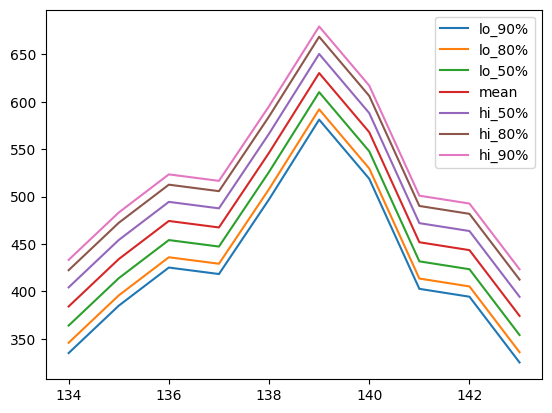

In [ ]:
#| hide
model.predict_in_sample(level=(80, 50, 90)).tail(10).plot()

In [ ]:
#| hide
model.model_.summary()

ARIMA(2,1,1)                   

Coefficients:
               ar1    ar2    ma1
coefficient  1.166 -0.460 -0.846
s.e.         0.004  0.006  0.007

sigma^2 = 893.391: log likelihood = -687.03

AIC=1382.05


In [ ]:
#| hide
model.summary()

ARIMA(2,1,1)                   

Coefficients:
               ar1    ar2    ma1
coefficient  1.166 -0.460 -0.846
s.e.         0.004  0.006  0.007

sigma^2 = 893.391: log likelihood = -687.03

AIC=1382.05


In [ ]:
#| hide
model_x = AutoARIMA(approximation=False)
model_x = model_x.fit(ap, np.hstack([np.sqrt(drift), np.log(drift)]))
model_x.predict(h=12, X=np.hstack([np.sqrt(newdrift), np.log(newdrift)]), level=(80, 90))

,lo_80%,lo_90%,mean,hi_80%,hi_90%
0,444.847980,434.808185,480.263454,515.678928,525.718723
1,414.132134,398.250657,470.154202,526.176269,542.057747
2,422.259388,403.968598,486.780331,551.301273,569.592064
3,398.925769,379.813613,466.344084,533.762400,552.874555
4,400.961841,381.849685,468.380156,535.798471,554.910627
5,402.992121,383.879965,470.410436,537.828751,556.940907
6,405.016660,385.904504,472.434975,539.853290,558.965446
7,407.035508,387.923352,474.453823,541.872139,560.984294
8,409.048715,389.936560,476.467031,543.885346,562.997502
9,411.056330,391.944175,478.474646,545.892961,565.005117


In [ ]:
#| hide
model_x.predict_in_sample()

,mean
0,73.205222
1,116.319093
2,100.318867
3,107.862711
4,108.927688
...,...
139,608.317570
140,564.682653
141,429.362239
142,442.344714


In [ ]:
#| hide
model_x.predict_in_sample(level=(80, 90))

,lo_90%,lo_80%,mean,hi_80%,hi_90%
0,27.749953,37.789748,73.205222,108.620696,118.660491
1,70.863824,80.903619,116.319093,151.734567,161.774362
2,54.863597,64.903392,100.318867,135.734341,145.774136
3,62.407442,72.447236,107.862711,143.278185,153.317980
4,63.472419,73.512214,108.927688,144.343162,154.382957
...,...,...,...,...,...
139,562.862301,572.902096,608.317570,643.733044,653.772839
140,519.227384,529.267179,564.682653,600.098127,610.137922
141,383.906970,393.946764,429.362239,464.777713,474.817508
142,396.889444,406.929239,442.344714,477.760188,487.799983


In [ ]:
#| hide
model_x.summary()

Regression with ARIMA(0,0,3) errors

Coefficients:
                ma1     ma2     ma3    ex_1    ex_2
coefficient   1.226   0.904   0.552  57.136 -45.774
s.e.         28.604  88.021  50.754  36.667  53.079

sigma^2 = 763.684: log likelihood = -679.81

AIC=1371.61


In [ ]:
#| hide
AutoARIMA().fit(np.array([1]*36)).predict(20, level=80)

,lo_80%,mean,hi_80%
0,1.0,1,1.0
1,1.0,1,1.0
2,1.0,1,1.0
3,1.0,1,1.0
4,1.0,1,1.0
5,1.0,1,1.0
6,1.0,1,1.0
7,1.0,1,1.0
8,1.0,1,1.0
9,1.0,1,1.0
